In [1]:
"""
Training Pipeline for LSTMABAR
Includes data loading, training loop, and evaluation
"""

import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import json
import librosa
from pathlib import Path
from typing import Dict, List, Optional, Tuple
import matplotlib.pyplot as plt

from lstmabar_model import LSTMABAR, LSTMABARTrainer
from musiccaps_loader import MusicCapsLoader

/Users/shanthgopalswamy/Desktop/mids266_final/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


=== Testing Archetype Prediction ===
Predicted weights shape: torch.Size([8, 5])
Sample prediction: tensor([0.2441, 0.1567, 0.2643, 0.1540, 0.1809], grad_fn=<SelectBackward0>)
Sum of weights: 1.000000 (should be ~1.0)

Named predictions for sample 0:
  sine: 0.4296
  square: 0.0383
  sawtooth: 0.1630
  triangle: 0.2392
  noise: 0.1298

=== Testing Archetype Loss ===
MSE loss: 0.0372

=== Testing RLHF Trainer with Audio Playback ===

HUMAN FEEDBACK COLLECTION

Description: 'bright and cutting guitar tone'

Predicted Archetype Weights:
  sine      : ████ 0.244
  square    : ███ 0.157
  sawtooth  : █████ 0.264
  triangle  : ███ 0.154
  noise     : ███ 0.181

------------------------------------------------------------
AUDIO PLAYBACK
------------------------------------------------------------

▶️  ORIGINAL AUDIO:



▶️  TRANSFORMED AUDIO:



------------------------------------------------------------
RATING INSTRUCTIONS
------------------------------------------------------------
Rate how well the transformation matches the description:
  5 = Perfect match
  4 = Good match
  3 = Acceptable match
  2 = Poor match
  1 = Very poor match

✓ Feedback recorded: 4.0/5


=== Interactive RLHF Usage Example ===

# In Jupyter notebook, use this pattern:

# 1. Generate or load audio samples
original_audio = librosa.load('input.wav')[0]
transformed_audio = model.transform(original_audio, description)

# 2. Get embeddings and predictions
text_emb = text_encoder([description])
audio_emb = audio_encoder(torch.from_numpy(original_audio))
predicted_weights = predictor(text_emb, audio_emb)

# 3. Collect interactive feedback with audio playback
rating = rlhf_trainer.collect_feedback_with_audio(
description="bright and crunchy",
original_audio=original_audio,
transformed_audio=transformed_audio,
predicted_weights=predicted_weights[0].cpu().n

In [2]:
class MusicCapsDataset(Dataset):
    """
    PyTorch Dataset for MusicCaps with archetype annotations
    """
    
    def __init__(
        self,
        training_data_path: str,
        sample_rate: int = 44100,
        audio_duration: float = 2.0,
        augment: bool = False
    ):
        """
        Args:
            training_data_path: Path to .npz file with training data
            sample_rate: Audio sample rate
            audio_duration: Duration to load from each audio file
            augment: Whether to apply data augmentation
        """
        self.sample_rate = sample_rate
        self.audio_duration = audio_duration
        self.augment = augment
        self.target_samples = int(sample_rate * audio_duration)
        
        # Load training data
        print(f"Loading training data from {training_data_path}")
        data = np.load(training_data_path, allow_pickle=True)
        
        self.archetype_vectors = torch.from_numpy(data['archetype_vectors']).float()
        self.descriptions = data['descriptions'].tolist()
        self.audio_paths = data['audio_paths'].tolist()
        self.archetype_order = data['archetype_order'].tolist()
        
        print(f"Loaded {len(self.descriptions)} training examples")
        
        # Filter out samples with missing audio files
        self.valid_indices = self._find_valid_samples()
        print(f"Found {len(self.valid_indices)} samples with valid audio files")
    
    def _find_valid_samples(self) -> List[int]:
        """Find indices with existing audio files"""
        valid = []
        for i, audio_path in enumerate(self.audio_paths):
            if Path(audio_path).exists():
                valid.append(i)
        return valid
    
    def __len__(self) -> int:
        return len(self.valid_indices)
    
    def __getitem__(self, idx: int) -> Dict:
        """
        Get a single training sample
        
        Returns:
            Dict with 'audio', 'description', 'archetype_weights'
        """
        # Map to valid index
        actual_idx = self.valid_indices[idx]
        
        # Load audio
        audio_path = self.audio_paths[actual_idx]
        audio, sr = librosa.load(
            audio_path,
            sr=self.sample_rate,
            duration=self.audio_duration
        )
        
        # Pad or trim to exact length
        if len(audio) < self.target_samples:
            audio = np.pad(audio, (0, self.target_samples - len(audio)))
        else:
            audio = audio[:self.target_samples]
        
        # Apply augmentation if enabled
        if self.augment:
            audio = self._augment_audio(audio)
        
        # Convert to tensor
        audio_tensor = torch.from_numpy(audio).float()
        
        # Get description and archetype weights
        description = self.descriptions[actual_idx]
        archetype_weights = self.archetype_vectors[actual_idx]
        
        return {
            'audio': audio_tensor,
            'description': description,
            'archetype_weights': archetype_weights
        }
    
    def _augment_audio(self, audio: np.ndarray) -> np.ndarray:
        """Apply random audio augmentations"""
        # Random gain (±3dB)
        if np.random.random() > 0.5:
            gain_db = np.random.uniform(-3, 3)
            audio = audio * (10 ** (gain_db / 20))
        
        # Random time shift
        if np.random.random() > 0.5:
            shift = np.random.randint(-self.sample_rate // 10, self.sample_rate // 10)
            audio = np.roll(audio, shift)
        
        # Add slight noise
        if np.random.random() > 0.5:
            noise = np.random.randn(len(audio)) * 0.005
            audio = audio + noise
        
        return audio


def collate_fn(batch: List[Dict]) -> Dict:
    """
    Custom collate function for DataLoader
    Handles variable-length descriptions
    """
    audio = torch.stack([item['audio'] for item in batch])
    descriptions = [item['description'] for item in batch]
    archetype_weights = torch.stack([item['archetype_weights'] for item in batch])
    
    return {
        'audio': audio,
        'descriptions': descriptions,
        'archetype_weights': archetype_weights
    }

In [3]:
class TrainingPipeline:
    """
    Complete training pipeline for LSTMABAR
    """
    
    def __init__(
        self,
        model: LSTMABAR,
        train_dataset: MusicCapsDataset,
        val_dataset: Optional[MusicCapsDataset] = None,
        batch_size: int = 16,
        learning_rate: float = 1e-4,
        num_epochs: int = 50,
        checkpoint_dir: str = 'checkpoints',
        log_interval: int = 10
    ):
        self.model = model
        self.train_dataset = train_dataset
        self.val_dataset = val_dataset
        self.batch_size = batch_size
        self.num_epochs = num_epochs
        self.checkpoint_dir = Path(checkpoint_dir)
        self.log_interval = log_interval
        
        # Create checkpoint directory
        self.checkpoint_dir.mkdir(exist_ok=True)
        
        # Create data loaders
        self.train_loader = DataLoader(
            train_dataset,
            batch_size=batch_size,
            shuffle=True,
            collate_fn=collate_fn,
            num_workers=0,
            pin_memory=True
        )
        
        if val_dataset is not None:
            self.val_loader = DataLoader(
                val_dataset,
                batch_size=batch_size,
                shuffle=False,
                collate_fn=collate_fn,
                num_workers=0,
                pin_memory=True
            )
        else:
            self.val_loader = None
        
        # Initialize trainer
        self.trainer = LSTMABARTrainer(
            model,
            learning_rate=learning_rate,
            loss_weights={
                'contrastive': 0.7,
                'archetype_prediction': 0.2,
                'audio_archetype_supervision': 0.1
            }
        )
        
        print(f"Training pipeline initialized:")
        print(f"  Training samples: {len(train_dataset)}")
        print(f"  Validation samples: {len(val_dataset) if val_dataset else 0}")
        print(f"  Batch size: {batch_size}")
        print(f"  Total epochs: {num_epochs}")
        print(f"  Steps per epoch: {len(self.train_loader)}")
    
    def train(self):
        """Run complete training loop"""
        best_val_loss = float('inf')
        
        for epoch in range(self.num_epochs):
            print(f"\n{'='*60}")
            print(f"Epoch {epoch+1}/{self.num_epochs}")
            print(f"{'='*60}")
            
            # Training
            train_losses = self.trainer.train_epoch(self.train_loader, epoch)
            print(f"\nTrain Losses: {train_losses}")
            
            # Validation
            if self.val_loader is not None:
                val_losses = {'total': 0.0}
                for batch in self.val_loader:
                    batch_losses = self.trainer.validate(
                        batch['descriptions'],
                        batch['audio'].to(self.model.device),
                        batch['archetype_weights'].to(self.model.device)
                    )
                    for key in batch_losses:
                        val_losses[key] = val_losses.get(key, 0.0) + batch_losses[key]
                
                # Average validation losses
                for key in val_losses:
                    val_losses[key] /= len(self.val_loader)
                
                print(f"Val Losses: {val_losses}")
                
                # Save best model
                if val_losses['total'] < best_val_loss:
                    best_val_loss = val_losses['total']
                    save_path = self.checkpoint_dir / 'best_model.pth'
                    self.model.save_checkpoint(
                        str(save_path),
                        epoch,
                        self.trainer.optimizer.state_dict()
                    )
                    print(f"✓ Best model saved (val_loss: {best_val_loss:.4f})")
            
            # Save periodic checkpoint
            if (epoch + 1) % 10 == 0:
                save_path = self.checkpoint_dir / f'checkpoint_epoch_{epoch+1}.pth'
                self.model.save_checkpoint(
                    str(save_path),
                    epoch,
                    self.trainer.optimizer.state_dict()
                )
        
        print(f"\n{'='*60}")
        print("Training complete!")
        print(f"{'='*60}")
        
        # Save final model
        final_path = self.checkpoint_dir / 'final_model.pth'
        self.model.save_checkpoint(
            str(final_path),
            self.num_epochs - 1,
            self.trainer.optimizer.state_dict()
        )
        
        # Plot training history
        self.plot_training_history()
    
    def plot_training_history(self):
        """Plot training curves"""
        history = self.trainer.history
        
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        
        # Total loss
        axes[0].plot(history['train_loss'], label='Train Loss')
        if history['val_loss']:
            axes[0].plot(history['val_loss'], label='Val Loss')
        axes[0].set_xlabel('Epoch')
        axes[0].set_ylabel('Loss')
        axes[0].set_title('Total Loss')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)
        
        # Component losses
        axes[1].plot(history['contrastive_loss'], label='Contrastive Loss')
        axes[1].plot(history['archetype_loss'], label='Archetype Loss')
        axes[1].set_xlabel('Epoch')
        axes[1].set_ylabel('Loss')
        axes[1].set_title('Component Losses')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig(self.checkpoint_dir / 'training_history.png', dpi=300)
        print(f"Training history plot saved to {self.checkpoint_dir / 'training_history.png'}")
        plt.close()


def prepare_musiccaps_data(
    csv_path: str,
    audio_dir: str = 'musiccaps_audio',
    output_path: str = 'musiccaps_training_data.npz',
    max_downloads: int = 500,
    train_split: float = 0.7,
    val_split: float = 0.15,
    test_split: float = 0.15,
    random_seed: int = 42
) -> Tuple[str, str]:
    """
    Prepare MusicCaps dataset for training

    Args:
        csv_path: Path to MusicCaps CSV
        audio_dir: Directory to save audio
        output_path: Base path for output files
        max_downloads: Max clips to download
        train_split: Fraction for training (default 0.7)
        val_split: Fraction for validation (default 0.15)
        test_split: Fraction for testing (default 0.15)
        random_seed: Random seed for reproducibility
    
    Returns:
        Tuple of (train_path, val_path, test_path) .npz files
    """

    assert abs(train_split + val_split + test_split - 1.0) < 1e-6, \
        "Splits must sum to 1.0"

    print("=== Preparing MusicCaps Dataset ===")
    
    # Load and process MusicCaps
    loader = MusicCapsLoader(csv_path, audio_dir)
    
    # Download audio clips
    print(f"\nDownloading up to {max_downloads} audio clips...")
    downloaded, failed = loader.download_audio_clips(
        max_clips=max_downloads,
        use_balanced_subset=True
    )
    
    print(f"Successfully downloaded: {len(downloaded)}")
    print(f"Failed: {len(failed)}")
    
    # Create archetype training data
    print("\nCreating archetype training data...")
    training_data = loader.create_archetype_training_data(use_tfidf_weighting=True)
    
    # Shuffle data for random splits
    np.random.seed(random_seed)
    indices = np.random.permutation(len(training_data))
    training_data = [training_data[i] for i in indices]
    
    # Calculate split points
    n_total = len(training_data)
    n_train = int(n_total * train_split)
    n_val = int(n_total * val_split)
    n_test = n_total - n_train - n_val
    
    # Split data
    train_data = training_data[:n_train]
    val_data = training_data[n_train:n_train + n_val]
    test_data = training_data[n_train + n_val:]
    
    print(f"\nDataset split:")
    print(f"  Train: {len(train_data)} samples ({train_split*100:.1f}%)")
    print(f"  Val:   {len(val_data)} samples ({val_split*100:.1f}%)")
    print(f"  Test:  {len(test_data)} samples ({test_split*100:.1f}%)")
    
    # Save train set
    train_path = output_path.replace('.npz', '_train.npz')
    vectors_train = np.array([item['archetype_vector'] for item in train_data])
    descriptions_train = [item['description'] for item in train_data]
    audio_paths_train = [item['audio_path'] for item in train_data]
    
    np.savez_compressed(
        train_path,
        archetype_vectors=vectors_train,
        descriptions=descriptions_train,
        audio_paths=audio_paths_train,
        archetype_order=train_data[0]['archetype_order']
    )
    print(f"\n✓ Saved train set: {train_path}")
    
    # Save val set
    val_path = output_path.replace('.npz', '_val.npz')
    vectors_val = np.array([item['archetype_vector'] for item in val_data])
    descriptions_val = [item['description'] for item in val_data]
    audio_paths_val = [item['audio_path'] for item in val_data]
    
    np.savez_compressed(
        val_path,
        archetype_vectors=vectors_val,
        descriptions=descriptions_val,
        audio_paths=audio_paths_val,
        archetype_order=val_data[0]['archetype_order']
    )
    print(f"✓ Saved val set: {val_path}")
    
    # Save test set
    test_path = output_path.replace('.npz', '_test.npz')
    vectors_test = np.array([item['archetype_vector'] for item in test_data])
    descriptions_test = [item['description'] for item in test_data]
    audio_paths_test = [item['audio_path'] for item in test_data]
    
    np.savez_compressed(
        test_path,
        archetype_vectors=vectors_test,
        descriptions=descriptions_test,
        audio_paths=audio_paths_test,
        archetype_order=test_data[0]['archetype_order']
    )
    print(f"✓ Saved test set: {test_path}")
    
    return train_path, val_path, test_path

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}\n")

# Configuration
config = {
    'embedding_dim': 768,
    'audio_architecture': 'resnet',  # or 'ast'
    'sample_rate': 44100,
    'audio_duration': 2.0,
    'batch_size': 16,
    'learning_rate': 1e-4,
    'num_epochs': 20,
    'max_downloads': 500
}

Using device: cpu



In [5]:
# Step 0: Download data (run once)

import kagglehub

# Download latest version
path = kagglehub.dataset_download("googleai/musiccaps")

print("Path to dataset files:", path)

csv_path = f"{path}/musiccaps-public.csv"

Path to dataset files: /Users/shanthgopalswamy/.cache/kagglehub/datasets/googleai/musiccaps/versions/1


In [6]:
# Step 1: Prepare dataset (run once)
print("Step 1: Preparing MusicCaps dataset with train/val/test split...")
train_data_path, val_data_path, test_data_path = prepare_musiccaps_data(
    csv_path=csv_path,
    audio_dir='musiccaps_audio',
    max_downloads=config['max_downloads'],
    train_split=0.7,
    val_split=0.15,
    test_split=0.15,
    random_seed=42
)

Step 1: Preparing MusicCaps dataset with train/val/test split...
=== Preparing MusicCaps Dataset ===
Loaded 5521 MusicCaps examples

Using balanced subset: 1000 examples
✓ Already exists: -bgHkxwoliw
✓ Already exists: -kpR93atgd8
✓ Already exists: -wymN80CiYU
✓ Already exists: 07xGXxIHOL4
✓ Already exists: 0PMFAO4TIU4
✓ Already exists: 0TV9zvfwFhs
✓ Already exists: 0fiOM---7QI


ERROR: [youtube] 0i8VM_EooCs: Video unavailable. This video is no longer available due to a copyright claim by Terrabyte Music Limited


Error downloading 0i8VM_EooCs: ERROR: [youtube] 0i8VM_EooCs: Video unavailable. This video is no longer available due to a copyright claim by Terrabyte Music Limited
✗ Failed: 0i8VM_EooCs
✓ Already exists: 0jFQ21A6GRA
✓ Already exists: 1ACn3u5UnBw
✓ Already exists: 1BVSYfNCcv0
✓ Already exists: 1JpeDWbgUO8
✓ Already exists: 1PKxdTlquCA
✓ Already exists: 1Q9DXhXMSFI
✓ Already exists: 1TyOPtg0Yfk
✓ Already exists: 1V7ReAk9k-4
✓ Already exists: 1j4rFfU5XKQ
✓ Already exists: 20Vh6z6Ie0E


ERROR: [youtube] 2G5bSYHcJSM: Video unavailable. This video is no longer available because the YouTube account associated with this video has been terminated.


Error downloading 2G5bSYHcJSM: ERROR: [youtube] 2G5bSYHcJSM: Video unavailable. This video is no longer available because the YouTube account associated with this video has been terminated.
✗ Failed: 2G5bSYHcJSM
✓ Already exists: 2GWkKVHxGRM
✓ Already exists: 2JnlmS1zzls
✓ Already exists: 2RU4CSDzS-g
✓ Already exists: 2U8Dvh7nwFI
✓ Already exists: 2ZfthfWQowE
✓ Already exists: 2bCuw7U_Rac
✓ Already exists: 2dyEnOo3yJ8
✓ Already exists: 2vQTq4QLP8U
✓ Already exists: 2xGRCsW6-Bk
✓ Already exists: 3JYQgXudiH8
✓ Already exists: 3TQmts_MxyQ
✓ Already exists: 40D4L5Ndi6k
✓ Already exists: 44sbWBFswUY
✓ Already exists: 4i11P4OCRfk
✓ Already exists: 5JQIsqc8HBc
✓ Already exists: 5XXAeSybGK0
✓ Already exists: 5ZpVhmhVYoI
✓ Already exists: 5_orEetudIA
✓ Already exists: 5gyMt0YzPQ0
✓ Already exists: 60OIHit4Q-M
✓ Already exists: 6N1LWG4aztA
✓ Already exists: 6k4lcF9IGUk
✓ Already exists: 7-mNJ4IUY5Q
✓ Already exists: 7WZwlOrRELI
✓ Already exists: 7_q36NyJtQY
✓ Already exists: 8BJljuSm2Aw
✓ Alread

ERROR: Postprocessing: WARNING: unable to obtain file audio codec with ffprobe


Error downloading BXo1Tr_oJds: ERROR: Postprocessing: WARNING: unable to obtain file audio codec with ffprobe
✗ Failed: BXo1Tr_oJds
✓ Already exists: Bl-lCgr5hGY
✓ Already exists: BnkDQXlrIX4
✓ Already exists: Byk9p21g51g
✓ Already exists: C5MhO2HM2Wg
✓ Already exists: C6roSYqchkk
✓ Already exists: C8VECv8kicU
✓ Already exists: CJjyrDGmxIY
✓ Already exists: CP3phqztym0
✓ Already exists: CRxIJ7YbcZA
✓ Already exists: CWQvCCRuU6k
✓ Already exists: CZuH43NPynA
✓ Already exists: Cchf2QH63bI
✓ Already exists: ChyayWIp_vU
✓ Already exists: CphwhKgYHaM
✓ Already exists: CzMNiypg1I8


ERROR: [youtube] Czbi1u-gwUU: Video unavailable. This video is no longer available due to a copyright claim by Cheb Hasni


Error downloading Czbi1u-gwUU: ERROR: [youtube] Czbi1u-gwUU: Video unavailable. This video is no longer available due to a copyright claim by Cheb Hasni
✗ Failed: Czbi1u-gwUU
✓ Already exists: D2w3qHmJrdU
✓ Already exists: D3FyfFIKLVc
✓ Already exists: D4ccFYk3bhU


ERROR: [youtube] D8-x1T8M4gk: Video unavailable. This video has been removed by the uploader


Error downloading D8-x1T8M4gk: ERROR: [youtube] D8-x1T8M4gk: Video unavailable. This video has been removed by the uploader
✗ Failed: D8-x1T8M4gk
✓ Already exists: DAPGvg8qOAU
✓ Already exists: DCFrCX4HPO8
✓ Already exists: DG5d4megH8g
✓ Already exists: DGbMEkQerYs
✓ Already exists: DKflAAykh6A
✓ Already exists: DP2vmsftZHY
✓ Already exists: DU5pD63Pv30
✓ Already exists: DaiVfxATCEE
✓ Already exists: DdxW_JziHTA


ERROR: [youtube] DysXetu2I0E: Video unavailable


Error downloading DysXetu2I0E: ERROR: [youtube] DysXetu2I0E: Video unavailable
✗ Failed: DysXetu2I0E
✓ Already exists: EKZvq0dUk50
✓ Already exists: EUNTykrvpok
✓ Already exists: EaGhKzpkNso


ERROR: [youtube] EfUUgsioXyU: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies


Error downloading EfUUgsioXyU: ERROR: [youtube] EfUUgsioXyU: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies
✗ Failed: EfUUgsioXyU
✓ Already exists: EmSZKb0LdVM
✓ Already exists: Es9FNjZ-SHI
✓ Already exists: FCzMqo8kh1o
✓ Already exists: FDO5BekX478
✓ Already exists: FENJIDecy5s
✓ Already exists: Fsm-xDmyFKg
✓ Already exists: FsnRM2irjvI
✓ Already exists: FteW_2gNtD4


ERROR: [youtube] Fv9swdLA-lo: Video unavailable. This video is no longer available because the YouTube account associated with this video has been terminated.


Error downloading Fv9swdLA-lo: ERROR: [youtube] Fv9swdLA-lo: Video unavailable. This video is no longer available because the YouTube account associated with this video has been terminated.
✗ Failed: Fv9swdLA-lo
✓ Already exists: G2uCAwYS6w0
✓ Already exists: GHQlBD-6rkA
✓ Already exists: GJYhDjThTHM
✓ Already exists: GLIXnXZEOxY
✓ Already exists: GPSqrciDLog
✓ Already exists: GQbUpJFArKI
✓ Already exists: GYCfrx0ruz4
✓ Already exists: GbjtSTTEFK4
✓ Already exists: Gc8xf7CJiFY
✓ Already exists: GkB_BkyVyPs
✓ Already exists: Guu30szkA-0
✓ Already exists: H6qzijVEqZQ
✓ Already exists: HFH9tcIK_PM
✓ Already exists: HFVM5pVTwkM
✓ Already exists: HHTgjmgTV6c
✓ Already exists: HNf9eHqDT1A
✓ Already exists: HS_ikHx4LIQ
✓ Already exists: HU7oqkJeItQ
✓ Already exists: HYjSrwSm0T4
✓ Already exists: HfzEa06vDLg
✓ Already exists: Hg4f2xt3oKA
✓ Already exists: HkXSX7Kdhms
✓ Already exists: Hnk45Z0EAxg
✓ Already exists: HzXWXYxXyYA
✓ Already exists: ID4AoAfHMVk
✓ Already exists: IKq2OF8jq1c
✓ Alread

ERROR: [youtube] LRfVQsnaVQE: Video unavailable. This video is no longer available because the YouTube account associated with this video has been terminated.


Error downloading LRfVQsnaVQE: ERROR: [youtube] LRfVQsnaVQE: Video unavailable. This video is no longer available because the YouTube account associated with this video has been terminated.
✗ Failed: LRfVQsnaVQE
✓ Already exists: L_nC2BvhRdQ
✓ Already exists: LfvdxSBCtFE
✓ Already exists: LjihfG0fit0
✓ Already exists: LybSS4amIS0
✓ Already exists: LzSWdj4izHM
✓ Already exists: MHkfPjW0aRg
✓ Already exists: MIexFfOsuJs
✓ Already exists: MKikHxKeodA
✓ Already exists: MM0seezR2F4
✓ Already exists: MVYSWTF11Nc
✓ Already exists: MY0PsDE3xHs
✓ Already exists: MdYXznF3Eac
✓ Already exists: MpWGx5odhh8
✓ Already exists: MsjeOXuUYG4
✓ Already exists: MvnC1TfNiPY
✓ Already exists: MzUgHy7SyS8
✓ Already exists: N-dzfI3L5ic
✓ Already exists: NHA1l_Czm38
✓ Already exists: N_Wx35sNqdM
✓ Already exists: NlCfScKw_Mk
✓ Already exists: NsYVaRI6rXg
✓ Already exists: Nt0U-CXK6O0
✓ Already exists: NwA9JSlK_lM
✓ Already exists: O1RmrE_HfpE
✓ Already exists: OB7GyVqufwQ
✓ Already exists: OEjgIDubFbg
✓ Alread

ERROR: [youtube] T6iv9GFIVyU: Video unavailable. This video is no longer available due to a copyright claim by Rishad Zahir


Error downloading T6iv9GFIVyU: ERROR: [youtube] T6iv9GFIVyU: Video unavailable. This video is no longer available due to a copyright claim by Rishad Zahir
✗ Failed: T6iv9GFIVyU
✓ Already exists: T7A0RejsZIo
✓ Already exists: T7ZSZhcsfjA
✓ Already exists: TN53jpjqAGI
✓ Already exists: TPYNIc_M1ng
✓ Already exists: Tp8PG2xae8c
✓ Already exists: Tsmx6Pb7CnU
✓ Already exists: TworrkXAPuI
✓ Already exists: TzPuAqjoL80
✓ Already exists: U4UtZeTl2DE
✓ Already exists: UDN11Q90Fa4
✓ Already exists: UFyOGqmITjM
✓ Already exists: UIOnnpaqBy8
✓ Already exists: UNJswfXKJ3s
✓ Already exists: UQKLBsZJsww
✓ Already exists: UcabTrKowlI
✓ Already exists: UnFEqUWTefM
✓ Already exists: UoxHwOl2gN0
✓ Already exists: UrgzGbGVV8I
✓ Already exists: UsdoUjuczY4
✓ Already exists: UtZofZjccBs
✓ Already exists: UvCY9FHpKC8
✓ Already exists: V3Vvp5HS90k
✓ Already exists: V9jIsOTC1lY
✓ Already exists: VCusyLPrFCo
✓ Already exists: VG6-MlmCgzI
✓ Already exists: VHYxygh1STA
✓ Already exists: VL6uF-XeE_A
✓ Already exi

ERROR: [youtube] W0aT3SdtnfY: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies


Error downloading W0aT3SdtnfY: ERROR: [youtube] W0aT3SdtnfY: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies
✗ Failed: W0aT3SdtnfY
✓ Already exists: W3lKc2hj4XU
✓ Already exists: W7U-glgu4GM
✓ Already exists: WCifI6rwOoM
✓ Already exists: WEVBqGarEIY
✓ Already exists: WMtztIW1f6k
✓ Already exists: WPguqXCBQCI
✓ Already exists: WTVC7ZI9WtY
✓ Already exists: WT_wvvEvkw4
✓ Already exists: WaddbqEQ1NE


ERROR: [youtube] We0WIPYrtRE: Video unavailable


Error downloading We0WIPYrtRE: ERROR: [youtube] We0WIPYrtRE: Video unavailable
✗ Failed: We0WIPYrtRE
✓ Already exists: WeDA1mDFSCo
✓ Already exists: WgZ8KAnnTb8
✓ Already exists: WsDb16qzA5Q
✓ Already exists: WtN6uiDikRM
✓ Already exists: X96v9LlsjJM
✓ Already exists: XE4NRSDLYG8
✓ Already exists: XUD-9HkQuTE
✓ Already exists: XXBVsNt2Qr8
✓ Already exists: XYOnq7ju7o0
✓ Already exists: XgOA5oRkL2A
✓ Already exists: XjUmXwVlDDo
✓ Already exists: XkBXsaSXDJ0


ERROR: [youtube] XvtL_TTLXHY: Video unavailable


Error downloading XvtL_TTLXHY: ERROR: [youtube] XvtL_TTLXHY: Video unavailable
✗ Failed: XvtL_TTLXHY
✓ Already exists: XwhAoMLNYWQ
✓ Already exists: XykUpCigu4w
✓ Already exists: Y7mTjfgcybQ
✓ Already exists: YZx0_GRtvJk
✓ Already exists: YcWJUHWt-64
✓ Already exists: YrGQKTbiG1g
✓ Already exists: YzpzKyzyL0Y
✓ Already exists: Z31gI08SMzI
✓ Already exists: Z7V7Curou7s
✓ Already exists: Z8L3jychP14
✓ Already exists: ZEuY5HnECuo
✓ Already exists: ZFimyfPWltk
✓ Already exists: ZJHlHb-VyDc
✓ Already exists: ZLXW4ewrVpQ
✓ Already exists: ZMd8mAKe-k8
✓ Already exists: ZNGvyFsCx4g
✓ Already exists: ZUcHBeueBww
✓ Already exists: ZUkh168Nyus
✓ Already exists: ZaUaqnLdg6k
✓ Already exists: Zhurw43-Y1g
✓ Already exists: ZkfKOLp5SxU
✓ Already exists: Zlbo8ygfPSM
✓ Already exists: ZmgkpmzvL6c
✓ Already exists: ZoAfkpmztww
✓ Already exists: ZsmfIMEzrQs
✓ Already exists: Zt8x7tvP9Qs
✓ Already exists: Zz1Bz1a7yPE


ERROR: [youtube] _3OlK_1yQOk: Video unavailable. This video contains content from Storm Labels Inc., who has blocked it on copyright grounds


Error downloading _3OlK_1yQOk: ERROR: [youtube] _3OlK_1yQOk: Video unavailable. This video contains content from Storm Labels Inc., who has blocked it on copyright grounds
✗ Failed: _3OlK_1yQOk
✓ Already exists: _43OOP6UEw0
✓ Already exists: _78P-0zWJtg
✓ Already exists: _9OUh0uwDec
✓ Already exists: _R9Ma9rjEWg
✓ Already exists: _b5n-mny1lM
✓ Already exists: _fKntnlIYTQ
✓ Already exists: _gWEpDgPAho
✓ Already exists: _h2rFVPCSPE
✓ Already exists: _lq8nEXh064
✓ Already exists: _m-N4i-ge28
✓ Already exists: _mQ6KuA2p6k
✓ Already exists: _n3r2inlqBc
✓ Already exists: _n9boKzVRhs
✓ Already exists: _yXtw_z2xf4
✓ Already exists: a2Wuroc8DQU
✓ Already exists: aJHv6TV7JpY
✓ Already exists: aOGNUGgTQ8k
✓ Already exists: aPQTrv2B1sw
✓ Already exists: aUH12rRIVDw
✓ Already exists: aUXKK9AmrPU
✓ Already exists: aUvHaURNgY8
✓ Already exists: aW6greyYuO4
✓ Already exists: aWK9CcvOK9w
✓ Already exists: aY8-pXDdwiw
✓ Already exists: ad6UhYwTXXQ
✓ Already exists: adYFXYPqo2M
✓ Already exists: ajy9PM2S

ERROR: [youtube] cADT8fUucLQ: Video unavailable. This video is no longer available because the YouTube account associated with this video has been terminated.


Error downloading cADT8fUucLQ: ERROR: [youtube] cADT8fUucLQ: Video unavailable. This video is no longer available because the YouTube account associated with this video has been terminated.
✗ Failed: cADT8fUucLQ
✓ Already exists: cBd0yZ27dtA
✓ Already exists: cGUhG5PZp0A
✓ Already exists: cS2gRhH6it4
✓ Already exists: cXEJWtj2kT8
✓ Already exists: cYRsnYEPIiM
✓ Already exists: cbq6Q2htPRM
✓ Already exists: chw8sAKOM5k
✓ Already exists: clefr8E-iZQ
✓ Already exists: cnvmLwFZr28
✓ Already exists: cp8t27oT_ww
✓ Already exists: cs-zcTX2tRA
✓ Already exists: d1nz5tZckSA
✓ Already exists: dBAeAk7dXnU
✓ Already exists: dMAp3dvs3kE
✓ Already exists: dNOHIxD0j_Q
✓ Already exists: dSJpZQ8u_xY
✓ Already exists: dSs4xfvATjc
✓ Already exists: darQBSIlol8
✓ Already exists: deIj55UAxeo


ERROR: [youtube] doX8FjlNPf8: Video unavailable. This video is no longer available because the YouTube account associated with this video has been terminated.


Error downloading doX8FjlNPf8: ERROR: [youtube] doX8FjlNPf8: Video unavailable. This video is no longer available because the YouTube account associated with this video has been terminated.
✗ Failed: doX8FjlNPf8
✓ Already exists: dvDSgmqbrM0
✓ Already exists: dwAo0dKCyBI
✓ Already exists: dwFtlQLdbq0
✓ Already exists: dwSj0Rr3vFc
✓ Already exists: dy_yFZ6dL34
✓ Already exists: e1KHGfMekek
✓ Already exists: e2tZmQI8ICw
✓ Already exists: e7WPFeDPFB4
✓ Already exists: e8wnUU5pIWE


ERROR: [youtube] eHeUipPZHIc: Video unavailable. This video contains content from SVG Music, who has blocked it on copyright grounds


Error downloading eHeUipPZHIc: ERROR: [youtube] eHeUipPZHIc: Video unavailable. This video contains content from SVG Music, who has blocked it on copyright grounds
✗ Failed: eHeUipPZHIc
✓ Already exists: eI4PbSh6g_Y
✓ Already exists: eM0PkfqGmIE
✓ Already exists: eOmQbJljnqE
✓ Already exists: eQTK2fo3RoE
✓ Already exists: eSesh6vnek8
✓ Already exists: eStzDzEopDI
✓ Already exists: eW8se7t0s-U
✓ Already exists: eWwWwoQLtVg
✓ Already exists: eXWBC3XfiXY
✓ Already exists: eXrJL1VUQNE
✓ Already exists: eYngZ5It0b8
✓ Already exists: eZE0RmJESFU
✓ Already exists: eZNnuRvrZDU
✓ Already exists: e_W17jp40G4
✓ Already exists: efTVnvwI2PQ
✓ Already exists: eiFyXXqd9Rk
✓ Already exists: eiUjc4UPnSs
✓ Already exists: esIzFH7vYLY
✓ Already exists: euAQCWBX6ns
✓ Already exists: evscfdO-oSY
✓ Already exists: f3l6KnC8930
✓ Already exists: f8nysknTFUo
✓ Already exists: fEfe8jznp5Q
✓ Already exists: fH9CY48sfJY
✓ Already exists: fHNAxa0QaOM
✓ Already exists: fPYeqTFc3IQ
✓ Already exists: fWypK9RHJJI
✓ Al

ERROR: [youtube] fZyq2pM2-dI: Video unavailable. This video is no longer available because the YouTube account associated with this video has been terminated.


Error downloading fZyq2pM2-dI: ERROR: [youtube] fZyq2pM2-dI: Video unavailable. This video is no longer available because the YouTube account associated with this video has been terminated.
✗ Failed: fZyq2pM2-dI
✓ Already exists: feC0L9MtghM
✓ Already exists: fer_4HvG3aY
✓ Already exists: fgCTFyzKQtk
✓ Already exists: fhWzjWZqzvs
✓ Already exists: fow1TC_MpHs
✓ Already exists: fsTVRca31nI
✓ Already exists: fsXfBoNcLeM
✓ Already exists: ftaHv79hRoY
✓ Already exists: fvw3Bi0GONA
✓ Already exists: g0scnRzoo9M
✓ Already exists: g4xhZgKwiNo


ERROR: [youtube] g8USMvt9np0: We're processing this video. Check back later.


Error downloading g8USMvt9np0: ERROR: [youtube] g8USMvt9np0: We're processing this video. Check back later.
✗ Failed: g8USMvt9np0
✓ Already exists: gAURHUoIK0M
✓ Already exists: gBuLpP4klvI
✓ Already exists: gDm4IphrlYg
✓ Already exists: gDnJoHpSL4M
✓ Already exists: gDzi8N3BYMw
✓ Already exists: gEvCUcZ6w88
✓ Already exists: gFxLnprPgv4
✓ Already exists: gRn6OjQf2ZQ
✓ Already exists: gWRfk8nCcPs
✓ Already exists: gXOyw8a4_Xs
✓ Already exists: g_bgmnJ1b_g


ERROR: [youtube] gdtw54I8soM: Video unavailable


Error downloading gdtw54I8soM: ERROR: [youtube] gdtw54I8soM: Video unavailable
✗ Failed: gdtw54I8soM
✓ Already exists: giPa2vVEyVc
✓ Already exists: gjJWbtCShqo
✓ Already exists: gsBXngKgy-Q
✓ Already exists: guRyU4B5LlA
✓ Already exists: guYWKdxrtIg
✓ Already exists: gxzU5EqNL14
✓ Already exists: h0-6U948u7Y
✓ Already exists: h8JS_FEF_fY
✓ Already exists: hDsA_ky9Hfw
✓ Already exists: hDzmNYd_eaA
✓ Already exists: hFj0KUzofNg
✓ Already exists: hFqZZrj0rnM
✓ Already exists: hQ5OBio4Cy0
✓ Already exists: hRbukCd6N68


ERROR: [youtube] hTAWbHXCJ2A: Sign in to confirm your age. This video may be inappropriate for some users. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies


Error downloading hTAWbHXCJ2A: ERROR: [youtube] hTAWbHXCJ2A: Sign in to confirm your age. This video may be inappropriate for some users. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies
✗ Failed: hTAWbHXCJ2A
✓ Already exists: hTNKYJ6suII
✓ Already exists: hUcuXIvDN2E
✓ Already exists: hVPQu1UJ2N8
✓ Already exists: hgitRq_0410
✓ Already exists: hlquKjPgxmY
✓ Already exists: hpiFoinUgvY
✓ Already exists: hqQvatf1RUY
✓ Already exists: hu6sChY-Yps
✓ Already exists: i6WtNBpRll0
✓ Already exists: i6k1yiyO5jQ
✓ Already exists: iBH5X5SKirU
✓ Already exists: iBezxlI_f_c
✓ Already exists: iCIa_pmLDqs
✓ Already exists: iEMTTKA7NxU


ERROR: [youtube] iEQwupwwp0s: The uploader has not made this video available in your country
This video is available in United Arab Emirates, Afghanistan, Albania, Armenia, Angola, Antarctica, Argentina, American Samoa, Australia, Aruba, Åland Islands, Azerbaijan, Bosnia and Herzegovina, Bangladesh, Burkina Faso, Bulgaria, Bahrain, Benin, Bermuda, Brunei Darussalam, Bolivia, Plurinational State of, Bonaire, Sint Eustatius and Saba, Brazil, Bhutan, Bouvet Island, Botswana, Belarus, Belize, Cocos (Keeling) Islands, Congo, the Democratic Republic of the, Central African Republic, Congo, Côte d'Ivoire, Cook Islands, Chile, Cameroon, China, Colombia, Costa Rica, Cape Verde, Curaçao, Christmas Island, Cyprus, Czech Republic, Denmark, Ecuador, Estonia, Western Sahara, Spain, Finland, Fiji, Falkland Islands (Malvinas), Micronesia, Federated States of, Faroe Islands, Gabon, Georgia, French Guiana, Guernsey, Ghana, Gibraltar, Greenland, Gambia, Guinea, Guadeloupe, Equatorial Guinea, Greece, Sout

Error downloading iEQwupwwp0s: ERROR: [youtube] iEQwupwwp0s: The uploader has not made this video available in your country
This video is available in United Arab Emirates, Afghanistan, Albania, Armenia, Angola, Antarctica, Argentina, American Samoa, Australia, Aruba, Åland Islands, Azerbaijan, Bosnia and Herzegovina, Bangladesh, Burkina Faso, Bulgaria, Bahrain, Benin, Bermuda, Brunei Darussalam, Bolivia, Plurinational State of, Bonaire, Sint Eustatius and Saba, Brazil, Bhutan, Bouvet Island, Botswana, Belarus, Belize, Cocos (Keeling) Islands, Congo, the Democratic Republic of the, Central African Republic, Congo, Côte d'Ivoire, Cook Islands, Chile, Cameroon, China, Colombia, Costa Rica, Cape Verde, Curaçao, Christmas Island, Cyprus, Czech Republic, Denmark, Ecuador, Estonia, Western Sahara, Spain, Finland, Fiji, Falkland Islands (Malvinas), Micronesia, Federated States of, Faroe Islands, Gabon, Georgia, French Guiana, Guernsey, Ghana, Gibraltar, Greenland, Gambia, Guinea, Guadeloupe, 

ERROR: [youtube] iXgEQj1Fs7g: Video unavailable. This video is no longer available because the YouTube account associated with this video has been terminated.


Error downloading iXgEQj1Fs7g: ERROR: [youtube] iXgEQj1Fs7g: Video unavailable. This video is no longer available because the YouTube account associated with this video has been terminated.
✗ Failed: iXgEQj1Fs7g
✓ Already exists: iZjIuV_cTe8

=== Download Summary ===
Successfully downloaded: 477
Failed: 23
Successfully downloaded: 477
Failed: 23

Creating archetype training data...

=== Archetype Distribution Statistics ===

SINE:
  Mean weight: 0.431
  Std dev: 0.392
  Max weight: 1.000
  % samples with weight > 0.3: 48.6%

SQUARE:
  Mean weight: 0.138
  Std dev: 0.253
  Max weight: 1.000
  % samples with weight > 0.3: 15.1%

SAWTOOTH:
  Mean weight: 0.198
  Std dev: 0.311
  Max weight: 1.000
  % samples with weight > 0.3: 21.6%

TRIANGLE:
  Mean weight: 0.144
  Std dev: 0.248
  Max weight: 1.000
  % samples with weight > 0.3: 15.1%

NOISE:
  Mean weight: 0.088
  Std dev: 0.187
  Max weight: 1.000
  % samples with weight > 0.3: 8.8%

=== Examples with Dominant Archetypes ===

SINE dom

In [7]:
# Step 2: Create datasets
print("\nStep 2: Creating PyTorch datasets...")
train_dataset = MusicCapsDataset(
    train_data_path,
    sample_rate=config['sample_rate'],
    audio_duration=config['audio_duration'],
    augment=True
)

val_dataset = MusicCapsDataset(
    val_data_path,
    sample_rate=config['sample_rate'],
    audio_duration=config['audio_duration'],
    augment=False
)

test_dataset = MusicCapsDataset(
    test_data_path,
    sample_rate=config['sample_rate'],
    audio_duration=config['audio_duration'],
    augment=False
)


Step 2: Creating PyTorch datasets...
Loading training data from musiccaps_training_data_train.npz
Loaded 333 training examples
Found 333 samples with valid audio files
Loading training data from musiccaps_training_data_val.npz
Loaded 71 training examples
Found 71 samples with valid audio files
Loading training data from musiccaps_training_data_test.npz
Loaded 73 training examples
Found 73 samples with valid audio files


In [ ]:
# Cell 1: Reload the modules to pick up changes
import importlib
import text_tower
import lstmabar_model

importlib.reload(text_tower)
importlib.reload(lstmabar_model)

# Re-import the classes
from text_tower import TextEncoder
from lstmabar_model import LSTMABAR, LSTMABARTrainer

In [8]:
# Step 3: Initialize model
print("\nStep 3: Initializing LSTMABAR model...")
model = LSTMABAR(
    embedding_dim=config['embedding_dim'],
    audio_architecture=config['audio_architecture'],
    sample_rate=config['sample_rate'],
    use_quantum_attention=False,
    device=device
)

print(f"Model has {sum(p.numel() for p in model.parameters()):,} parameters")


Step 3: Initializing LSTMABAR model...
Loading text encoder: sentence-transformers/all-MiniLM-L6-v2
Model has 37,203,724 parameters


In [9]:
# Step 4: Create training pipeline
print("\nStep 4: Setting up training pipeline...")
pipeline = TrainingPipeline(
    model=model,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    batch_size=config['batch_size'],
    learning_rate=config['learning_rate'],
    num_epochs=config['num_epochs'],
    checkpoint_dir='checkpoints'
)


Step 4: Setting up training pipeline...
Training pipeline initialized:
  Training samples: 333
  Validation samples: 71
  Batch size: 16
  Total epochs: 20
  Steps per epoch: 21


########

In [37]:
# Step 5: Train!
print("\nStep 5: Starting training...")
pipeline.train()

print("\n✓ Training complete! Model checkpoints saved to checkpoints/")


Step 5: Starting training...

Epoch 1/20


/Users/shanthgopalswamy/Desktop/mids266_final/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 0, Batch 0/21: Loss=1.9718, Contrastive=2.7729, Archetype=0.1024
Epoch 0, Batch 10/21: Loss=1.9569, Contrastive=2.7576, Archetype=0.0877
Epoch 0, Batch 20/21: Loss=1.8003, Contrastive=2.5298, Archetype=0.0973

Train Losses: {'total': np.float64(1.9567998023260207), 'contrastive': np.float64(2.751888933635893), 'archetype': np.float64(0.10551349180085319)}
Val Losses: {'total': 1.8490639925003052, 'contrastive': 2.6003254413604737, 'archetype': 0.09782975912094116}
Checkpoint saved to checkpoints/best_model.pth
✓ Best model saved (val_loss: 1.8491)

Epoch 2/20
Epoch 1, Batch 0/21: Loss=1.8529, Contrastive=2.6029, Archetype=0.1075
Epoch 1, Batch 10/21: Loss=1.8889, Contrastive=2.6589, Archetype=0.0963
Epoch 1, Batch 20/21: Loss=1.7524, Contrastive=2.4618, Archetype=0.0992

Train Losses: {'total': np.float64(1.8320271628243583), 'contrastive': np.float64(2.5745021729242232), 'archetype': np.float64(0.10390859984216236)}
Val Losses: {'total': 1.7285382747650146, 'contrastive': 2.4283

### Train w Quantum Attention

In [127]:
# Step 3: Initialize model
print("\nStep 3: Initializing LSTMABAR model...")
model = LSTMABAR(
    embedding_dim=config['embedding_dim'],
    audio_architecture=config['audio_architecture'],
    sample_rate=config['sample_rate'],
    use_quantum_attention=True,
    device=device
)

print(f"Model has {sum(p.numel() for p in model.parameters()):,} parameters")


Step 3: Initializing LSTMABAR model...
Loading text encoder: sentence-transformers/all-MiniLM-L6-v2
Model has 37,218,324 parameters


In [128]:
# Step 4: Create training pipeline
print("\nStep 4: Setting up training pipeline...")
pipeline = TrainingPipeline(
    model=model,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    batch_size=config['batch_size'],
    learning_rate=config['learning_rate'],
    num_epochs=config['num_epochs'],
    checkpoint_dir='checkpoints'
)


Step 4: Setting up training pipeline...
Training pipeline initialized:
  Training samples: 333
  Validation samples: 71
  Batch size: 16
  Total epochs: 20
  Steps per epoch: 21


In [129]:
# Step 5: Train!
print("\nStep 5: Starting training...")
pipeline.train()

print("\n✓ Training complete! Model checkpoints saved to checkpoints/")


Step 5: Starting training...

Epoch 1/20


/Users/shanthgopalswamy/Desktop/mids266_final/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 0, Batch 0/21: Loss=1.9744, Contrastive=2.7909, Archetype=0.0671
Epoch 0, Batch 10/21: Loss=1.9525, Contrastive=2.7353, Archetype=0.1304
Epoch 0, Batch 20/21: Loss=1.8132, Contrastive=2.5503, Archetype=0.0989

Train Losses: {'total': np.float64(1.9579165152141027), 'contrastive': np.float64(2.7539193516685847), 'archetype': np.float64(0.10385715039003462)}
Val Losses: {'total': 1.8472557544708252, 'contrastive': 2.598416638374329, 'archetype': 0.09531206637620926}
Checkpoint saved to checkpoints/best_model.pth
✓ Best model saved (val_loss: 1.8473)

Epoch 2/20
Epoch 1, Batch 0/21: Loss=1.8872, Contrastive=2.6400, Archetype=0.1384
Epoch 1, Batch 10/21: Loss=1.9105, Contrastive=2.6835, Archetype=0.1082
Epoch 1, Batch 20/21: Loss=1.7525, Contrastive=2.4619, Archetype=0.1039

Train Losses: {'total': np.float64(1.8488945904232206), 'contrastive': np.float64(2.5994325819469632), 'archetype': np.float64(0.10075967439583369)}
Val Losses: {'total': 1.807362937927246, 'contrastive': 2.54170

### Quantum 2 - add drop out, reduce circuit depth, removed QFT and Grover to reduce overfitting (all implemented in text_tower)

In [ ]:
config = {
    'embedding_dim': 768,
    'audio_architecture': 'resnet',  # or 'ast'
    'sample_rate': 44100,
    'audio_duration': 2.0,
    'batch_size': 16,
    'learning_rate': 1e-4,
    'num_epochs': 10,
    'max_downloads': 500
}

In [ ]:
# Step 3: Initialize model
print("\nStep 3: Initializing LSTMABAR model...")
model = LSTMABAR(
    embedding_dim=config['embedding_dim'],
    audio_architecture=config['audio_architecture'],
    sample_rate=config['sample_rate'],
    use_quantum_attention=True,
    device=device
)

print(f"Model has {sum(p.numel() for p in model.parameters()):,} parameters")

In [ ]:
# Step 4: Create training pipeline
print("\nStep 4: Setting up training pipeline...")
pipeline = TrainingPipeline(
    model=model,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    batch_size=config['batch_size'],
    learning_rate=config['learning_rate'],
    num_epochs=config['num_epochs'],
    checkpoint_dir='checkpoints'
)

In [ ]:
# Step 5: Train!
print("\nStep 5: Starting training...")
pipeline.train()

print("\n✓ Training complete! Model checkpoints saved to checkpoints/")

# Hyperparameter tuning

In [10]:
# Define configurations to test
hyperparameter_configs = [
    # Classical baseline configurations
    {
        'name': 'classical_baseline_small',
        'embedding_dim': 512,
        'audio_architecture': 'resnet',
        'batch_size': 32,
        'learning_rate': 1e-4,
        'num_epochs': 15,
        'use_quantum_attention': False,
        'dropout_rate': 0.1
    },
    {
        'name': 'classical_baseline_large',
        'embedding_dim': 768,
        'audio_architecture': 'resnet',
        'batch_size': 16,
        'learning_rate': 5e-5,
        'num_epochs': 15,
        'use_quantum_attention': False,
        'dropout_rate': 0.2
    },
    {
        'name': 'classical_ast',
        'embedding_dim': 768,
        'audio_architecture': 'ast',
        'batch_size': 16,
        'learning_rate': 1e-4,
        'num_epochs': 15,
        'use_quantum_attention': False,
        'dropout_rate': 0.15
    },
    
    # Quantum attention configurations
    {
        'name': 'quantum_4qubit_depth2',
        'embedding_dim': 768,
        'audio_architecture': 'resnet',
        'batch_size': 16,
        'learning_rate': 1e-4,
        'num_epochs': 15,
        'use_quantum_attention': True,
        'n_qubits': 4,
        'circuit_depth': 2,
        'dropout_rate': 0.3,
        'noise_strength': 0.1
    },
    {
        'name': 'quantum_6qubit_depth2',
        'embedding_dim': 768,
        'audio_architecture': 'resnet',
        'batch_size': 16,
        'learning_rate': 1e-4,
        'num_epochs': 15,
        'use_quantum_attention': True,
        'n_qubits': 6,
        'circuit_depth': 2,
        'dropout_rate': 0.3,
        'noise_strength': 0.1
    },
    {
        'name': 'quantum_8qubit_depth1',
        'embedding_dim': 768,
        'audio_architecture': 'resnet',
        'batch_size': 16,
        'learning_rate': 1e-4,
        'num_epochs': 15,
        'use_quantum_attention': True,
        'n_qubits': 8,
        'circuit_depth': 1,
        'dropout_rate': 0.3,
        'noise_strength': 0.05
    },
    {
        'name': 'quantum_8qubit_depth3_high_reg',
        'embedding_dim': 768,
        'audio_architecture': 'resnet',
        'batch_size': 16,
        'learning_rate': 5e-5,
        'num_epochs': 15,
        'use_quantum_attention': True,
        'n_qubits': 8,
        'circuit_depth': 3,
        'dropout_rate': 0.4,
        'noise_strength': 0.15
    },
]

print(f"Defined {len(hyperparameter_configs)} configurations to test")
print("\nConfigurations:")
for i, config in enumerate(hyperparameter_configs):
    print(f"  {i+1}. {config['name']}")

Defined 7 configurations to test

Configurations:
  1. classical_baseline_small
  2. classical_baseline_large
  3. classical_ast
  4. quantum_4qubit_depth2
  5. quantum_6qubit_depth2
  6. quantum_8qubit_depth1
  7. quantum_8qubit_depth3_high_reg


In [11]:
import json
from datetime import datetime
from pathlib import Path

def create_model_from_config(config, device):
    """
    Create LSTMABAR model from configuration dictionary
    
    Args:
        config: Dictionary with hyperparameters
        device: 'cuda' or 'cpu'
    
    Returns:
        Initialized LSTMABAR model
    """
    model_params = {
        'embedding_dim': config['embedding_dim'],
        'audio_architecture': config['audio_architecture'],
        'sample_rate': 44100,
        'use_quantum_attention': config['use_quantum_attention'],
        'device': device
    }
    
    # Add quantum-specific parameters if using quantum attention
    if config['use_quantum_attention']:
        model_params['n_qubits'] = config.get('n_qubits', 8)
    
    model = LSTMABAR(**model_params)
    
    return model


def log_training_results(config, train_losses, val_losses, training_time, results_dir='tuning_results'):
    """
    Log training results to JSON file
    
    Args:
        config: Configuration dictionary
        train_losses: Dictionary of training losses
        val_losses: Dictionary of validation losses
        training_time: Training duration in seconds
        results_dir: Directory to save results
    """
    results_dir = Path(results_dir)
    results_dir.mkdir(exist_ok=True)
    
    # Prepare results dictionary
    results = {
        'config': config,
        'training_time_seconds': training_time,
        'final_train_loss': train_losses['total'][-1] if train_losses['total'] else None,
        'final_val_loss': val_losses['total'][-1] if val_losses['total'] else None,
        'best_val_loss': min(val_losses['total']) if val_losses['total'] else None,
        'train_loss_history': train_losses,
        'val_loss_history': val_losses,
        'timestamp': datetime.now().isoformat()
    }
    
    # Save to JSON
    filename = f"{config['name']}_{datetime.now().strftime('%Y%m%d_%H%M%S')}.json"
    filepath = results_dir / filename
    
    with open(filepath, 'w') as f:
        json.dump(results, f, indent=2)
    
    print(f"✓ Results saved to {filepath}")
    
    return results


def print_config_summary(config):
    """Print a summary of the configuration"""
    print(f"\n{'='*70}")
    print(f"Configuration: {config['name']}")
    print(f"{'='*70}")
    print(f"  Embedding dim: {config['embedding_dim']}")
    print(f"  Architecture: {config['audio_architecture']}")
    print(f"  Batch size: {config['batch_size']}")
    print(f"  Learning rate: {config['learning_rate']}")
    print(f"  Epochs: {config['num_epochs']}")
    print(f"  Quantum attention: {config['use_quantum_attention']}")
    
    if config['use_quantum_attention']:
        print(f"  N qubits: {config.get('n_qubits', 8)}")
        print(f"  Circuit depth: {config.get('circuit_depth', 2)}")
        print(f"  Dropout rate: {config.get('dropout_rate', 0.3)}")
        print(f"  Noise strength: {config.get('noise_strength', 0.1)}")
    else:
        print(f"  Dropout rate: {config.get('dropout_rate', 0.1)}")
    
    print(f"{'='*70}\n")


In [12]:
import time

def train_single_config(config, train_dataset, val_dataset, device, checkpoint_base='tuning_checkpoints'):
    """
    Train model with a single configuration
    
    Args:
        config: Hyperparameter configuration dictionary
        train_dataset: Training dataset
        val_dataset: Validation dataset
        device: 'cuda' or 'cpu'
        checkpoint_base: Base directory for checkpoints
    
    Returns:
        Dictionary with training results
    """
    print_config_summary(config)
    
    # Create model
    print("Initializing model...")
    model = create_model_from_config(config, device)
    print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
    
    # Create checkpoint directory
    checkpoint_dir = Path(checkpoint_base) / config['name']
    checkpoint_dir.mkdir(parents=True, exist_ok=True)
    
    # Create training pipeline
    print("Creating training pipeline...")
    pipeline = TrainingPipeline(
        model=model,
        train_dataset=train_dataset,
        val_dataset=val_dataset,
        batch_size=config['batch_size'],
        learning_rate=config['learning_rate'],
        num_epochs=config['num_epochs'],
        checkpoint_dir=str(checkpoint_dir)
    )
    
    # Train
    print("Starting training...")
    start_time = time.time()
    
    try:
        pipeline.train()
        training_time = time.time() - start_time
        success = True
        error_msg = None
    except Exception as e:
        training_time = time.time() - start_time
        success = False
        error_msg = str(e)
        print(f"\n❌ Training failed: {e}")
        import traceback
        traceback.print_exc()
    
    # Extract training history
    train_losses = {
        'total': pipeline.trainer.history['train_loss'],
        'contrastive': pipeline.trainer.history['contrastive_loss'],
        'archetype': pipeline.trainer.history['archetype_loss']
    }
    
    val_losses = {
        'total': pipeline.trainer.history['val_loss']
    }
    
    # Log results
    results = log_training_results(config, train_losses, val_losses, training_time)
    results['success'] = success
    results['error'] = error_msg
    
    # Print summary
    print(f"\n{'='*70}")
    print(f"Training Summary: {config['name']}")
    print(f"{'='*70}")
    print(f"Status: {'✓ Success' if success else '✗ Failed'}")
    print(f"Training time: {training_time/60:.2f} minutes")
    if success and val_losses['total']:
        print(f"Best validation loss: {min(val_losses['total']):.4f}")
        print(f"Final validation loss: {val_losses['total'][-1]:.4f}")
    print(f"{'='*70}\n")
    
    return results

In [13]:
def run_hyperparameter_search(configs, train_dataset, val_dataset, device):
    """
    Run hyperparameter search across all configurations
    
    Args:
        configs: List of configuration dictionaries
        train_dataset: Training dataset
        val_dataset: Validation dataset
        device: 'cuda' or 'cpu'
    
    Returns:
        List of results for all configurations
    """
    all_results = []
    
    print(f"\n{'='*80}")
    print(f"STARTING HYPERPARAMETER SEARCH")
    print(f"{'='*80}")
    print(f"Total configurations: {len(configs)}")
    print(f"Device: {device}")
    print(f"{'='*80}\n")
    
    for i, config in enumerate(configs):
        print(f"\n{'#'*80}")
        print(f"Configuration {i+1}/{len(configs)}")
        print(f"{'#'*80}\n")
        
        results = train_single_config(config, train_dataset, val_dataset, device)
        all_results.append(results)
        
        # Save intermediate results
        intermediate_path = Path('tuning_results') / 'all_results_intermediate.json'
        with open(intermediate_path, 'w') as f:
            json.dump(all_results, f, indent=2)
    
    print(f"\n{'='*80}")
    print(f"HYPERPARAMETER SEARCH COMPLETE")
    print(f"{'='*80}\n")
    
    return all_results


In [14]:
# Execute the search
all_results = run_hyperparameter_search(
    hyperparameter_configs,
    train_dataset,
    val_dataset,
    device
)


STARTING HYPERPARAMETER SEARCH
Total configurations: 7
Device: cpu


################################################################################
Configuration 1/7
################################################################################


Configuration: classical_baseline_small
  Embedding dim: 512
  Architecture: resnet
  Batch size: 32
  Learning rate: 0.0001
  Epochs: 15
  Quantum attention: False
  Dropout rate: 0.1

Initializing model...
Loading text encoder: sentence-transformers/all-MiniLM-L6-v2
Model parameters: 36,055,564
Creating training pipeline...
Training pipeline initialized:
  Training samples: 333
  Validation samples: 71
  Batch size: 32
  Total epochs: 15
  Steps per epoch: 11
Starting training...

Epoch 1/15


/Users/shanthgopalswamy/Desktop/mids266_final/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 0, Batch 0/11: Loss=2.4636, Contrastive=3.4824, Archetype=0.0893
Epoch 0, Batch 10/11: Loss=1.7976, Contrastive=2.5348, Archetype=0.0776

Train Losses: {'total': np.float64(2.3925697044892744), 'contrastive': np.float64(3.3749203248457476), 'archetype': np.float64(0.10373613035137003)}


/Users/shanthgopalswamy/Desktop/mids266_final/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Val Losses: {'total': 2.130974849065145, 'contrastive': 3.0000675519307456, 'archetype': 0.10519582778215408}
Checkpoint saved to tuning_checkpoints/classical_baseline_small/best_model.pth
✓ Best model saved (val_loss: 2.1310)

Epoch 2/15
Epoch 1, Batch 0/11: Loss=2.4006, Contrastive=3.3810, Archetype=0.1159
Epoch 1, Batch 10/11: Loss=1.6049, Contrastive=2.2565, Archetype=0.0846

Train Losses: {'total': np.float64(2.271017453887246), 'contrastive': np.float64(3.202026692303744), 'archetype': np.float64(0.10148183459585364)}
Val Losses: {'total': 2.119427720705668, 'contrastive': 2.982790946960449, 'archetype': 0.10829959809780121}
Checkpoint saved to tuning_checkpoints/classical_baseline_small/best_model.pth
✓ Best model saved (val_loss: 2.1194)

Epoch 3/15
Epoch 2, Batch 0/11: Loss=2.2253, Contrastive=3.1391, Archetype=0.0927
Epoch 2, Batch 10/11: Loss=1.4247, Contrastive=1.9829, Archetype=0.1313

Train Losses: {'total': np.float64(2.0994899706407026), 'contrastive': np.float64(2.9573

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import json
from pathlib import Path

def load_results_from_json(results_dir='tuning_results'):
    """
    Load all results directly from JSON files
    
    Args:
        results_dir: Directory containing result JSON files
    
    Returns:
        List of result dictionaries loaded from JSON
    """
    results_dir = Path(results_dir)
    all_results = []
    
    # Find all JSON files except intermediate results
    json_files = [f for f in results_dir.glob('*.json') 
                  if 'intermediate' not in f.name and 'summary' not in f.name]
    
    print(f"Loading {len(json_files)} result files from {results_dir}")
    
    for json_file in sorted(json_files):
        with open(json_file, 'r') as f:
            result = json.load(f)
            all_results.append(result)
    
    return all_results

In [18]:
def analyze_results(all_results):
    """
    Analyze and compare results from hyperparameter search
    
    Args:
        all_results: List of result dictionaries
    
    Returns:
        DataFrame with summary statistics
    """
    # Extract key metrics
    summary_data = []
    for result in all_results:
        config = result['config']
        
        # Get the actual final losses from training history
        train_history = result.get('train_loss_history', {})
        val_history = result.get('val_loss_history', {})
        
        # Extract final training loss
        train_total = train_history.get('total', [])
        final_train_loss = train_total[-1] if train_total else None
        
        # Extract validation loss (if it exists)
        val_total = val_history.get('total', [])
        final_val_loss = val_total[-1] if val_total else None
        best_val_loss = min(val_total) if val_total else None
        
        # If no validation loss, use training loss as proxy
        if best_val_loss is None and train_total:
            best_val_loss = min(train_total)
            final_val_loss = train_total[-1]
            loss_type = 'train'
        else:
            loss_type = 'val'
        
        row = {
            'name': config['name'],
            'quantum': config['use_quantum_attention'],
            'embedding_dim': config['embedding_dim'],
            'architecture': config['audio_architecture'],
            'batch_size': config['batch_size'],
            'learning_rate': config['learning_rate'],
            'epochs': config['num_epochs'],
            'best_loss': best_val_loss,
            'final_loss': final_val_loss,
            'loss_type': loss_type,
            'training_time_min': result['training_time_seconds'] / 60,
            'success': result.get('success', True)
        }
        
        if config['use_quantum_attention']:
            row['n_qubits'] = config.get('n_qubits', 8)
            row['circuit_depth'] = config.get('circuit_depth', 'N/A')
            row['dropout'] = config.get('dropout_rate', 'N/A')
        
        summary_data.append(row)
    
    df = pd.DataFrame(summary_data)
    
    # Filter out failed runs
    df = df[df['success'] == True]
    
    if len(df) == 0:
        print("⚠️ No successful runs found!")
        return df
    
    # Sort by best loss
    df = df.sort_values('best_loss')
    
    print("\n" + "="*80)
    print("HYPERPARAMETER SEARCH RESULTS")
    print("="*80 + "\n")
    
    print("Top 5 Configurations by Loss:")
    display_cols = ['name', 'best_loss', 'final_loss', 'loss_type', 'training_time_min']
    print(df[display_cols].head().to_string(index=False))
    
    print("\n\nClassical vs Quantum Comparison:")
    classical_df = df[df['quantum'] == False]
    quantum_df = df[df['quantum'] == True]
    
    if len(classical_df) > 0:
        best_classical = classical_df.iloc[0]
        print(f"\nBest Classical Model:")
        print(f"  Name: {best_classical['name']}")
        print(f"  Loss: {best_classical['best_loss']:.4f} ({best_classical['loss_type']})")
        print(f"  Final Loss: {best_classical['final_loss']:.4f}")
        print(f"  Time: {best_classical['training_time_min']:.2f} min")
        print(f"  Architecture: {best_classical['architecture']}")
        print(f"  Embedding Dim: {best_classical['embedding_dim']}")
        print(f"  Batch Size: {best_classical['batch_size']}")
        print(f"  Learning Rate: {best_classical['learning_rate']}")
    
    if len(quantum_df) > 0:
        best_quantum = quantum_df.iloc[0]
        print(f"\nBest Quantum Model:")
        print(f"  Name: {best_quantum['name']}")
        print(f"  Loss: {best_quantum['best_loss']:.4f} ({best_quantum['loss_type']})")
        print(f"  Final Loss: {best_quantum['final_loss']:.4f}")
        print(f"  Time: {best_quantum['training_time_min']:.2f} min")
        print(f"  Qubits: {best_quantum.get('n_qubits', 'N/A')}")
        print(f"  Circuit Depth: {best_quantum.get('circuit_depth', 'N/A')}")
    
    # Compare classical vs quantum
    if len(classical_df) > 0 and len(quantum_df) > 0:
        print(f"\n{'='*80}")
        print("CLASSICAL vs QUANTUM COMPARISON")
        print(f"{'='*80}")
        
        classical_mean_loss = classical_df['best_loss'].mean()
        quantum_mean_loss = quantum_df['best_loss'].mean()
        classical_mean_time = classical_df['training_time_min'].mean()
        quantum_mean_time = quantum_df['training_time_min'].mean()
        
        print(f"\nClassical Average Loss: {classical_mean_loss:.4f}")
        print(f"Quantum Average Loss: {quantum_mean_loss:.4f}")
        
        if quantum_mean_loss < classical_mean_loss:
            improvement = ((classical_mean_loss - quantum_mean_loss) / classical_mean_loss) * 100
            print(f"✓ Quantum improves loss by {improvement:.2f}%")
        else:
            degradation = ((quantum_mean_loss - classical_mean_loss) / classical_mean_loss) * 100
            print(f"✗ Quantum increases loss by {degradation:.2f}%")
        
        print(f"\nClassical Average Training Time: {classical_mean_time:.2f} min")
        print(f"Quantum Average Training Time: {quantum_mean_time:.2f} min")
        
        time_overhead = ((quantum_mean_time - classical_mean_time) / classical_mean_time) * 100
        print(f"Quantum training time overhead: {time_overhead:.2f}%")
    
    # Save summary to CSV
    csv_path = 'tuning_results/summary.csv'
    df.to_csv(csv_path, index=False)
    print(f"\n✓ Summary saved to {csv_path}")
    
    return df

In [19]:
def plot_training_curves(all_results, results_dir='tuning_results'):
    """
    Plot training curves for all configurations
    
    Args:
        all_results: List of result dictionaries
        results_dir: Directory to save plots
    """
    results_dir = Path(results_dir)
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()
    
    # Plot each configuration's training curve
    for idx, result in enumerate(all_results[:6]):  # Plot first 6
        if idx >= len(axes):
            break
        
        ax = axes[idx]
        config = result['config']
        train_history = result.get('train_loss_history', {})
        
        # Plot training losses
        if 'total' in train_history and train_history['total']:
            epochs = range(1, len(train_history['total']) + 1)
            ax.plot(epochs, train_history['total'], 'b-', label='Total Loss', linewidth=2)
            
            if 'contrastive' in train_history and train_history['contrastive']:
                ax.plot(epochs, train_history['contrastive'], 'r--', 
                       label='Contrastive', alpha=0.7)
            
            if 'archetype' in train_history and train_history['archetype']:
                ax.plot(epochs, train_history['archetype'], 'g--', 
                       label='Archetype', alpha=0.7)
        
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')
        ax.set_title(config['name'], fontsize=10)
        ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3)
    
    # Hide unused subplots
    for idx in range(len(all_results), len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.savefig(results_dir / 'training_curves.png', dpi=300, bbox_inches='tight')
    print(f"✓ Training curves saved to {results_dir / 'training_curves.png'}")
    plt.show()


In [20]:
def plot_hyperparameter_comparison(results_df, results_dir='tuning_results'):
    """
    Create visualizations comparing different configurations
    
    Args:
        results_df: DataFrame with results
        results_dir: Directory to save plots
    """
    results_dir = Path(results_dir)
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Loss comparison
    ax = axes[0, 0]
    classical = results_df[results_df['quantum'] == False]
    quantum = results_df[results_df['quantum'] == True]
    
    x_classical = list(range(len(classical)))
    x_quantum = list(range(len(classical), len(classical) + len(quantum)))
    
    ax.bar(x_classical, classical['best_loss'], alpha=0.7, label='Classical', color='blue')
    ax.bar(x_quantum, quantum['best_loss'], alpha=0.7, label='Quantum', color='red')
    
    ax.set_xticks(list(range(len(results_df))))
    ax.set_xticklabels(results_df['name'], rotation=45, ha='right', fontsize=8)
    ax.set_ylabel('Best Loss')
    ax.set_title('Loss by Configuration')
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    
    # 2. Training time comparison
    ax = axes[0, 1]
    ax.bar(x_classical, classical['training_time_min'], alpha=0.7, 
           label='Classical', color='blue')
    ax.bar(x_quantum, quantum['training_time_min'], alpha=0.7, 
           label='Quantum', color='red')
    ax.set_xticks(list(range(len(results_df))))
    ax.set_xticklabels(results_df['name'], rotation=45, ha='right', fontsize=8)
    ax.set_ylabel('Training Time (minutes)')
    ax.set_title('Training Time by Configuration')
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    
    # 3. Loss vs Training Time scatter
    ax = axes[1, 0]
    ax.scatter(classical['training_time_min'], classical['best_loss'], 
               s=100, alpha=0.7, label='Classical', color='blue')
    ax.scatter(quantum['training_time_min'], quantum['best_loss'], 
               s=100, alpha=0.7, label='Quantum', color='red')
    
    for idx, row in results_df.iterrows():
        ax.annotate(row['name'], (row['training_time_min'], row['best_loss']),
                   fontsize=7, alpha=0.7)
    
    ax.set_xlabel('Training Time (minutes)')
    ax.set_ylabel('Best Loss')
    ax.set_title('Loss vs Training Time Trade-off')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 4. Configuration comparison
    ax = axes[1, 1]
    sorted_df = results_df.sort_values('best_loss')
    colors = ['blue' if not q else 'red' for q in sorted_df['quantum']]
    
    bars = ax.barh(range(len(sorted_df)), sorted_df['best_loss'], color=colors, alpha=0.7)
    ax.set_yticks(range(len(sorted_df)))
    ax.set_yticklabels(sorted_df['name'], fontsize=8)
    ax.set_xlabel('Best Loss')
    ax.set_title('All Configurations Ranked')
    ax.grid(True, alpha=0.3, axis='x')
    
    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='blue', alpha=0.7, label='Classical'),
        Patch(facecolor='red', alpha=0.7, label='Quantum')
    ]
    ax.legend(handles=legend_elements)
    
    plt.tight_layout()
    plt.savefig(results_dir / 'comparison_plots.png', dpi=300, bbox_inches='tight')
    print(f"✓ Comparison plots saved to {results_dir / 'comparison_plots.png'}")
    plt.show()

Loading results from JSON files...
Loading 10 result files from tuning_results

HYPERPARAMETER SEARCH RESULTS

Top 5 Configurations by Loss:
                    name  best_loss  final_loss loss_type  training_time_min
classical_baseline_large   0.175240    0.192721     train          33.172000
classical_baseline_large   0.188319    0.188319     train          32.870956
   quantum_8qubit_depth1   0.192730    0.192730     train          35.498052
   quantum_6qubit_depth2   0.193861    0.193861     train          34.053775
classical_baseline_small   0.199715    0.199715     train          32.121841


Classical vs Quantum Comparison:

Best Classical Model:
  Name: classical_baseline_large
  Loss: 0.1752 (train)
  Final Loss: 0.1927
  Time: 33.17 min
  Architecture: resnet
  Embedding Dim: 768
  Batch Size: 16
  Learning Rate: 5e-05

Best Quantum Model:
  Name: quantum_8qubit_depth1
  Loss: 0.1927 (train)
  Final Loss: 0.1927
  Time: 35.50 min
  Qubits: 8.0
  Circuit Depth: 1.0

CLASSICAL v

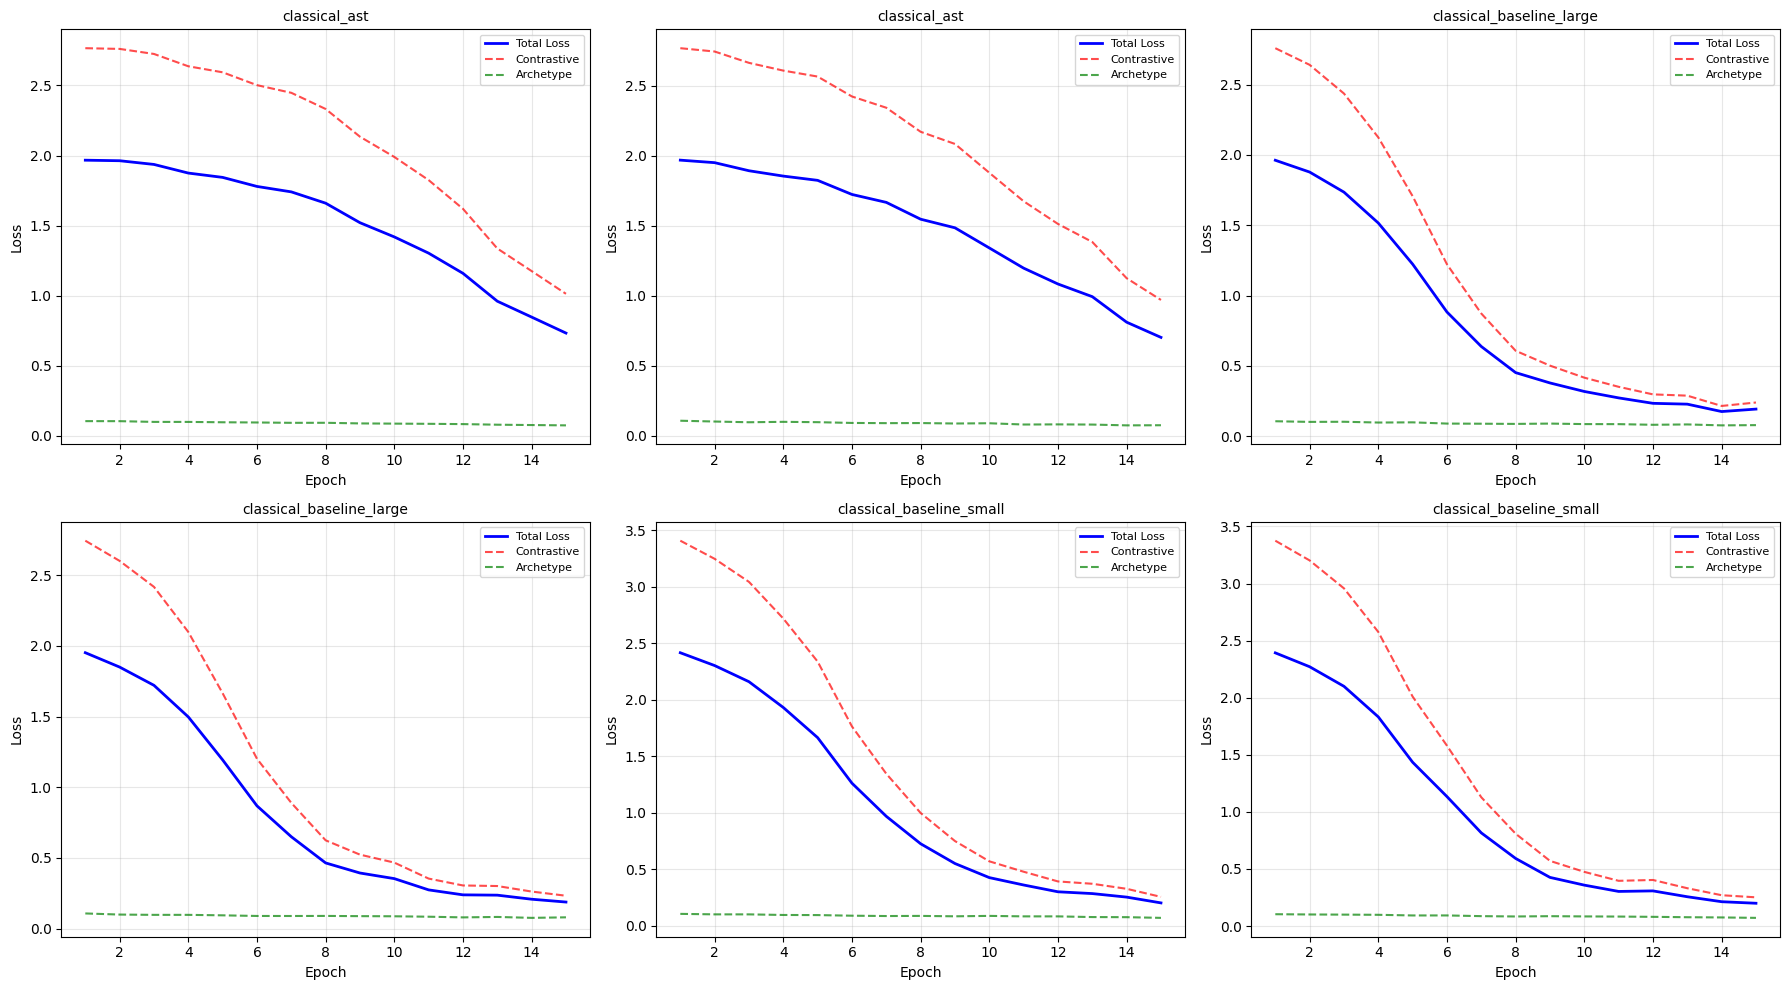

In [21]:
# Load results from JSON files
print("Loading results from JSON files...")
all_results = load_results_from_json('tuning_results')

# Analyze results
results_df = analyze_results(all_results)

# Plot training curves
if len(all_results) > 0:
    print("\nGenerating training curve plots...")
    plot_training_curves(all_results)

✓ Comparison plots saved to tuning_results/comparison_plots.png


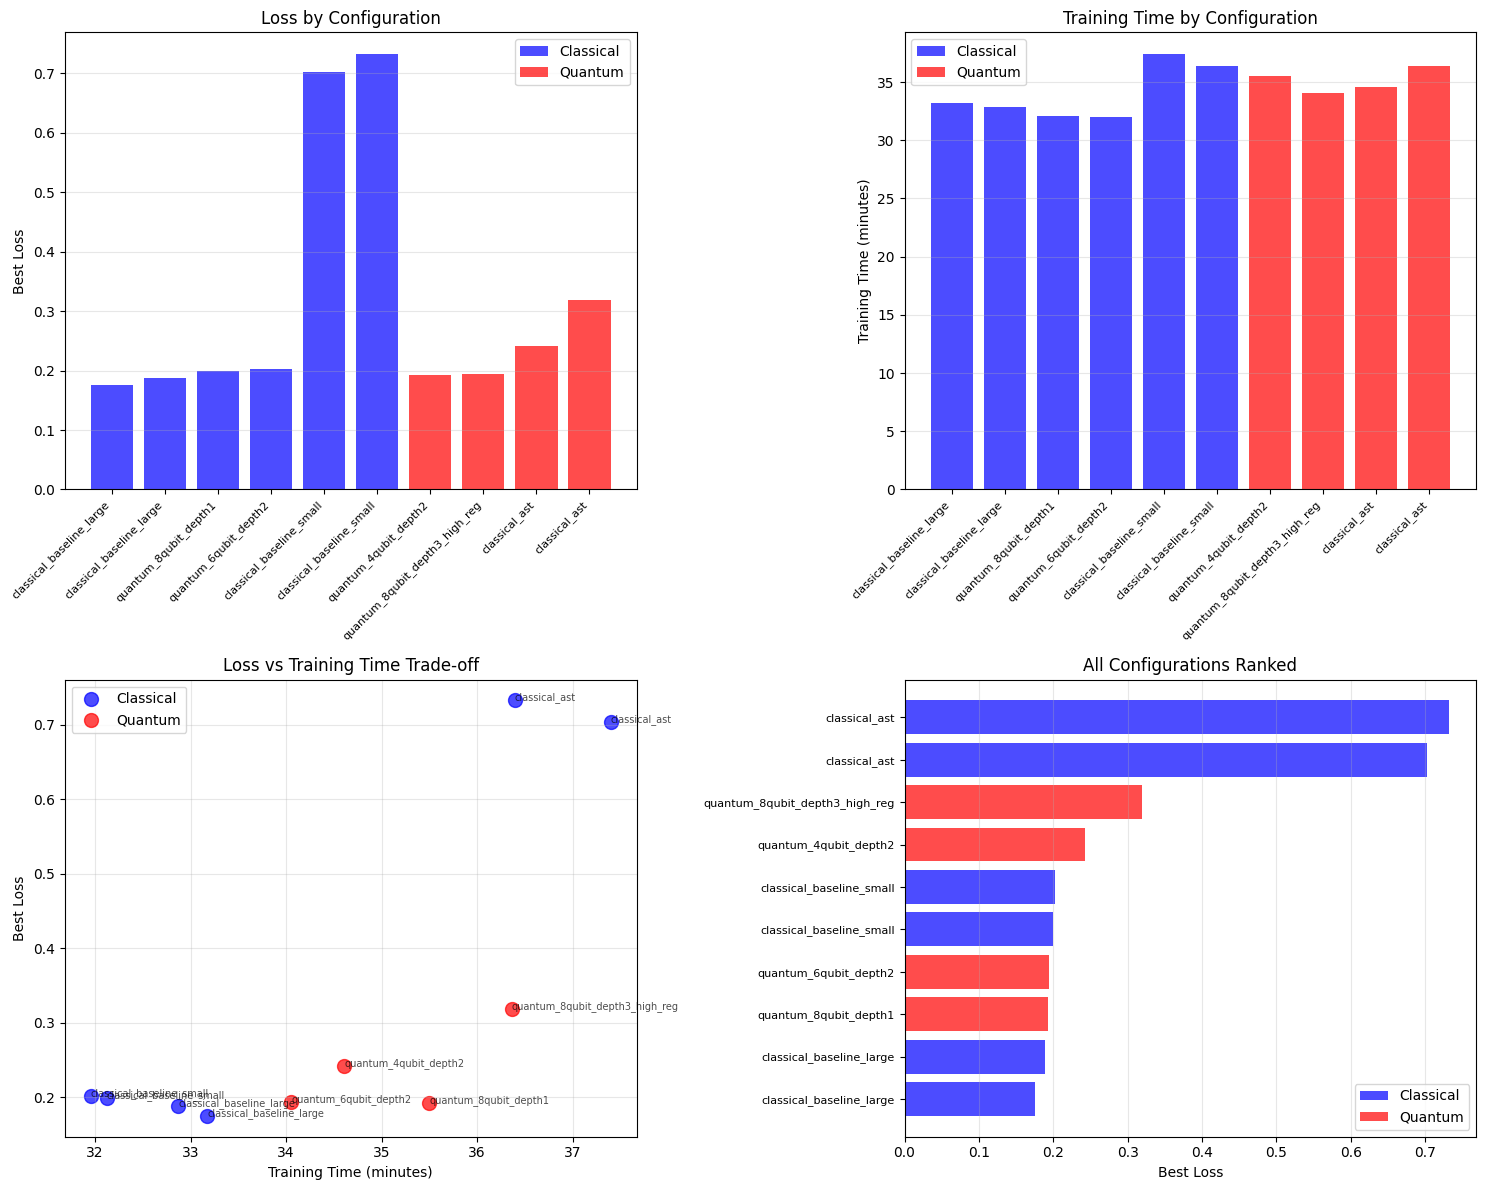

In [22]:
if len(results_df) > 0:
    plot_hyperparameter_comparison(results_df)
else:
    print("⚠️ No successful results to plot")

### Recover performance metrics from logs
validation results were not properly saved to tuning_results jsons, so we will re-attempt extraction

In [26]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def parse_tuning_logs(log_file_path):
    with open(log_file_path, 'r') as f:
        content = f.read()

    # Split content into configuration blocks
    # We look for the "Configuration: [name]" header
    config_blocks = re.split(r'={50,}\nConfiguration: ', content)[1:] # Skip preamble
    
    parsed_data = []

    for block in config_blocks:
        # 1. Extract Config Name
        name_match = re.match(r'([^\n]+)', block)
        config_name = name_match.group(1).strip() if name_match else "Unknown"
        
        # 2. Extract Hyperparameters (Optional, allows you to pivot data later)
        lr_match = re.search(r'Learning rate:\s+([\d.e-]+)', block)
        lr = float(lr_match.group(1)) if lr_match else None
        
        batch_match = re.search(r'Batch size:\s+(\d+)', block)
        batch = int(batch_match.group(1)) if batch_match else None
        
        # 3. Extract Epoch Data
        # We iterate through the block to find per-epoch losses
        # Regex explanation:
        # Looks for "Train Losses:" followed by "total": then optionally "np.float64(" then the number
        train_pattern = r"Train Losses: \{'total': (?:np\.float64\()?([\d\.]+)"
        val_pattern = r"Val Losses: \{'total': ([\d\.]+)"
        
        train_matches = re.findall(train_pattern, block)
        val_matches = re.findall(val_pattern, block)
        
        # Determine number of epochs found
        epochs = range(1, len(train_matches) + 1)
        
        for i, epoch in enumerate(epochs):
            # Safe extraction in case val_loss is missing for an epoch
            val_loss = float(val_matches[i]) if i < len(val_matches) else None
            train_loss = float(train_matches[i])
            
            entry = {
                'config_name': config_name,
                'epoch': epoch,
                'learning_rate': lr,
                'batch_size': batch,
                'train_loss': train_loss,
                'val_loss': val_loss
            }
            parsed_data.append(entry)

    return pd.DataFrame(parsed_data)


In [27]:
# --- EXECUTION ---
# 1. Save your cell output text to 'raw_tuning_logs.txt'
# 2. Run the parser
df_results = parse_tuning_logs('raw_tuning_logs.txt')

print(f"Successfully parsed {len(df_results)} data points.")
print(df_results.head())

# --- ANALYSIS ---

# 1. Find Best Configuration (Lowest Validation Loss)
best_config = df_results.loc[df_results['val_loss'].idxmin()]
print(f"\n🏆 Best Configuration: {best_config['config_name']}")
print(f"   Min Val Loss: {best_config['val_loss']}")
print(f"   Epoch: {best_config['epoch']}")

# 2. Pivot Table for easy comparison
summary = df_results.groupby('config_name').agg({
    'val_loss': ['min', 'last'], # Best loss and final loss
    'train_loss': 'last'
}).sort_values(('val_loss', 'min'))

print("\n📊 Leaderboard:")
print(summary)

Successfully parsed 105 data points.
                config_name  epoch  learning_rate  batch_size  train_loss  \
0  classical_baseline_small      1         0.0001          32    2.392570   
1  classical_baseline_small      2         0.0001          32    2.271017   
2  classical_baseline_small      3         0.0001          32    2.099490   
3  classical_baseline_small      4         0.0001          32    1.831753   
4  classical_baseline_small      5         0.0001          32    1.434532   

   val_loss  
0  2.130975  
1  2.119428  
2  2.106614  
3  2.144040  
4  2.096494  

🏆 Best Configuration: quantum_8qubit_depth3_high_reg
   Min Val Loss: 1.7025506019592285
   Epoch: 8

📊 Leaderboard:
                                val_loss           train_loss
                                     min      last       last
config_name                                                  
quantum_8qubit_depth3_high_reg  1.702551  2.001161   0.318821
classical_ast                   1.714513  2.027281

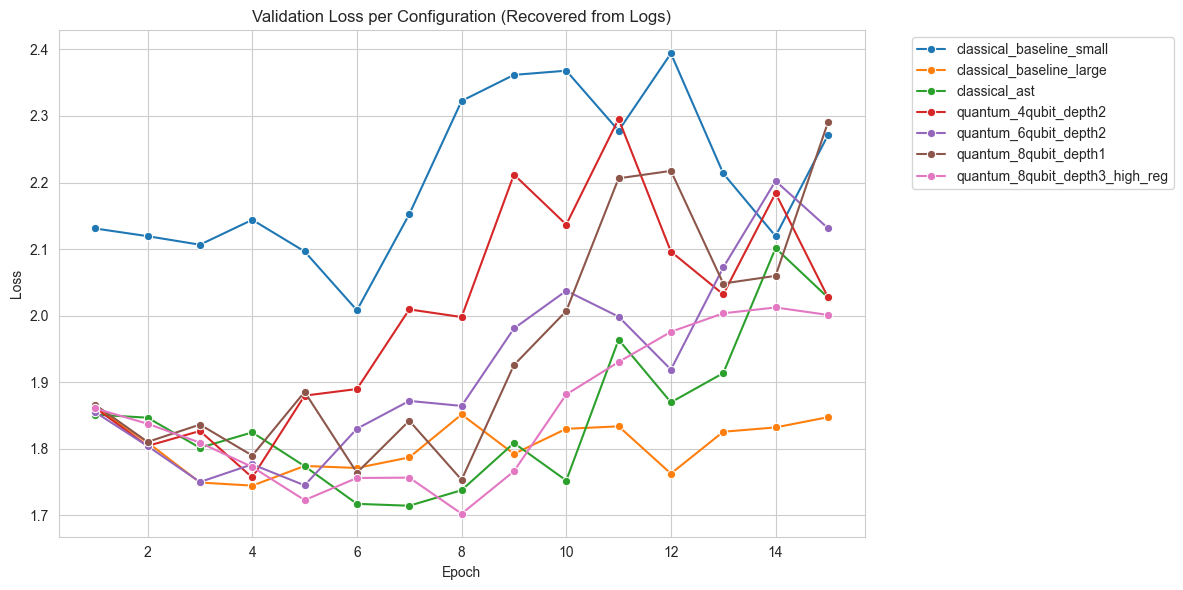

In [28]:
# Create a cleaner plot
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

# Plot Validation Loss curves
sns.lineplot(
    data=df_results,
    x='epoch', 
    y='val_loss', 
    hue='config_name',
    marker='o',
    dashes=False
)

plt.title('Validation Loss per Configuration (Recovered from Logs)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

#### Recreate analysis and visualization from before

In [31]:
def parse_logs_to_dataframe(log_file_path):
    with open(log_file_path, 'r') as f:
        content = f.read()

    # Split into config blocks
    config_blocks = re.split(r'={50,}\nConfiguration: ', content)[1:]
    
    epoch_data = []
    meta_data = []

    for block in config_blocks:
        # 1. Extract Name
        name_match = re.match(r'([^\n]+)', block)
        config_name = name_match.group(1).strip() if name_match else "Unknown"
        
        # 2. Extract Time (often at the bottom of the block)
        time_match = re.search(r'Training time:\s+([\d\.]+)\s+minutes', block)
        train_time_min = float(time_match.group(1)) if time_match else None

        # 3. Extract Epoch Losses
        # Regex to find: "Train Losses: {'total': 2.39..." and "Val Losses: {'total': 2.13..."
        train_matches = re.findall(r"Train Losses: \{'total': (?:np\.float64\()?([\d\.]+)", block)
        val_matches = re.findall(r"Val Losses: \{'total': (?:np\.float64\()?([\d\.]+)", block)
        
        # Capture Contrastive/Archetype if available (optional, but good for plotting)
        contrast_matches = re.findall(r"'contrastive': (?:np\.float64\()?([\d\.]+)", block)

        for i in range(len(train_matches)):
            row = {
                'name': config_name,
                'epoch': i + 1,
                'train_loss': float(train_matches[i]),
                'val_loss': float(val_matches[i]) if i < len(val_matches) else None,
                'contrastive_loss': float(contrast_matches[i]) if i < len(contrast_matches) else None
            }
            epoch_data.append(row)
            
        # Store metadata to merge later
        if train_time_min:
            meta_data.append({'name': config_name, 'training_time_min': train_time_min})

    return pd.DataFrame(epoch_data), pd.DataFrame(meta_data)

In [32]:
def analyze_results_from_logs(df_epochs, df_meta, original_configs):
    """
    Refactored to analyze parsed DataFrame instead of JSON results.
    merges:
      1. Aggregated stats from df_epochs (Best Loss, Final Loss)
      2. Time data from df_meta
      3. Static hyperparameters from original_configs
    """
    summary_rows = []

    # Map original configs for easy lookup
    config_map = {c['name']: c for c in original_configs}

    # Group by configuration name
    grouped = df_epochs.groupby('name')

    for name, group in grouped:
        if name not in config_map:
            continue
            
        orig_config = config_map[name]
        
        # Calculate Statistics
        val_losses = group['val_loss'].dropna()
        train_losses = group['train_loss'].dropna()
        
        # Determine best/final losses
        if not val_losses.empty:
            best_loss = val_losses.min()
            final_loss = val_losses.iloc[-1]
            loss_type = 'val'
        else:
            best_loss = train_losses.min()
            final_loss = train_losses.iloc[-1]
            loss_type = 'train (fallback)'

        # Get Training Time
        time_row = df_meta[df_meta['name'] == name]
        train_time = time_row['training_time_min'].values[0] if not time_row.empty else 0

        row = {
            'name': name,
            'quantum': orig_config['use_quantum_attention'],
            'embedding_dim': orig_config['embedding_dim'],
            'architecture': orig_config['audio_architecture'],
            'batch_size': orig_config['batch_size'],
            'learning_rate': orig_config['learning_rate'],
            'best_loss': best_loss,
            'final_loss': final_loss,
            'loss_type': loss_type,
            'training_time_min': train_time,
            'epochs_completed': len(group)
        }

        # Add Quantum Specifics
        if orig_config['use_quantum_attention']:
            row['n_qubits'] = orig_config.get('n_qubits', 8)
            row['circuit_depth'] = orig_config.get('circuit_depth', 'N/A')
        
        summary_rows.append(row)

    df_summary = pd.DataFrame(summary_rows).sort_values('best_loss')
    
    # --- PRINT SUMMARY ---
    print("\n" + "="*80)
    print("RECOVERED HYPERPARAMETER RESULTS")
    print("="*80 + "\n")
    
    display_cols = ['name', 'best_loss', 'epochs_completed', 'training_time_min']
    print(df_summary[display_cols].to_string(index=False))

    return df_summary


def plot_training_curves_from_logs(df_epochs, results_dir='tuning_results'):
    """
    Refactored to plot directly from the epoch-level DataFrame.
    """
    results_dir = Path(results_dir)
    results_dir.mkdir(exist_ok=True)
    
    unique_configs = df_epochs['name'].unique()
    num_configs = len(unique_configs)
    
    # Calculate grid size (approximate)
    cols = 3
    rows = (num_configs + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(18, 5 * rows))
    axes = axes.flatten()

    for idx, config_name in enumerate(unique_configs):
        ax = axes[idx]
        data = df_epochs[df_epochs['name'] == config_name]
        
        # Plot Total Train
        ax.plot(data['epoch'], data['train_loss'], 'b-', label='Train Loss', linewidth=2)
        
        # Plot Validation
        if data['val_loss'].notna().any():
            ax.plot(data['epoch'], data['val_loss'], 'r-', label='Val Loss', linewidth=2)
            
        # Plot Contrastive (if available)
        if 'contrastive_loss' in data.columns and data['contrastive_loss'].notna().any():
             ax.plot(data['epoch'], data['contrastive_loss'], 'g--', alpha=0.5, label='Contrastive')

        ax.set_title(config_name, fontsize=10, fontweight='bold')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')
        ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3)

    # Turn off unused subplots
    for idx in range(num_configs, len(axes)):
        axes[idx].axis('off')

    plt.tight_layout()
    plt.savefig(results_dir / 'recovered_training_curves.png', dpi=300)
    print(f"✓ Curves saved to {results_dir / 'recovered_training_curves.png'}")
    plt.show()


def plot_comparison_from_summary(df_summary, results_dir='tuning_results'):
    """
    Refactored to take the summary DataFrame directly.
    """
    results_dir = Path(results_dir)
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # 1. Bar Chart: Best Loss by Configuration
    ax = axes[0]
    
    # Color logic
    colors = ['#ff9999' if q else '#66b3ff' for q in df_summary['quantum']]
    
    bars = ax.barh(df_summary['name'], df_summary['best_loss'], color=colors)
    ax.set_xlabel('Best Validation Loss')
    ax.set_title('Leaderboard (Lower is Better)')
    ax.invert_yaxis() # Best on top
    
    # Legend
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor='#66b3ff', label='Classical'),
                       Patch(facecolor='#ff9999', label='Quantum')]
    ax.legend(handles=legend_elements)

    # 2. Scatter: Time vs Loss
    ax = axes[1]
    classical = df_summary[~df_summary['quantum']]
    quantum = df_summary[df_summary['quantum']]
    
    ax.scatter(classical['training_time_min'], classical['best_loss'], 
               c='#66b3ff', s=100, label='Classical', edgecolors='black')
    ax.scatter(quantum['training_time_min'], quantum['best_loss'], 
               c='#ff9999', s=100, label='Quantum', edgecolors='black')
    
    for _, row in df_summary.iterrows():
        ax.text(row['training_time_min'], row['best_loss'], 
                f"  {row['name']}", fontsize=8, va='center')

    ax.set_xlabel('Training Time (min)')
    ax.set_ylabel('Best Loss')
    ax.set_title('Efficiency Frontier: Time vs Accuracy')
    ax.legend()
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(results_dir / 'recovered_comparison.png', dpi=300)
    print(f"✓ Comparison plots saved to {results_dir / 'recovered_comparison.png'}")
    plt.show()


RECOVERED HYPERPARAMETER RESULTS

                          name  best_loss  epochs_completed  training_time_min
quantum_8qubit_depth3_high_reg   1.702551                15              36.37
                 classical_ast   1.714513                15              37.40
      classical_baseline_large   1.744711                15              32.87
         quantum_6qubit_depth2   1.745138                15              34.05
         quantum_8qubit_depth1   1.753453                15              35.50
         quantum_4qubit_depth2   1.757019                15              34.61
      classical_baseline_small   2.008144                15              32.12
✓ Curves saved to tuning_results/recovered_training_curves.png


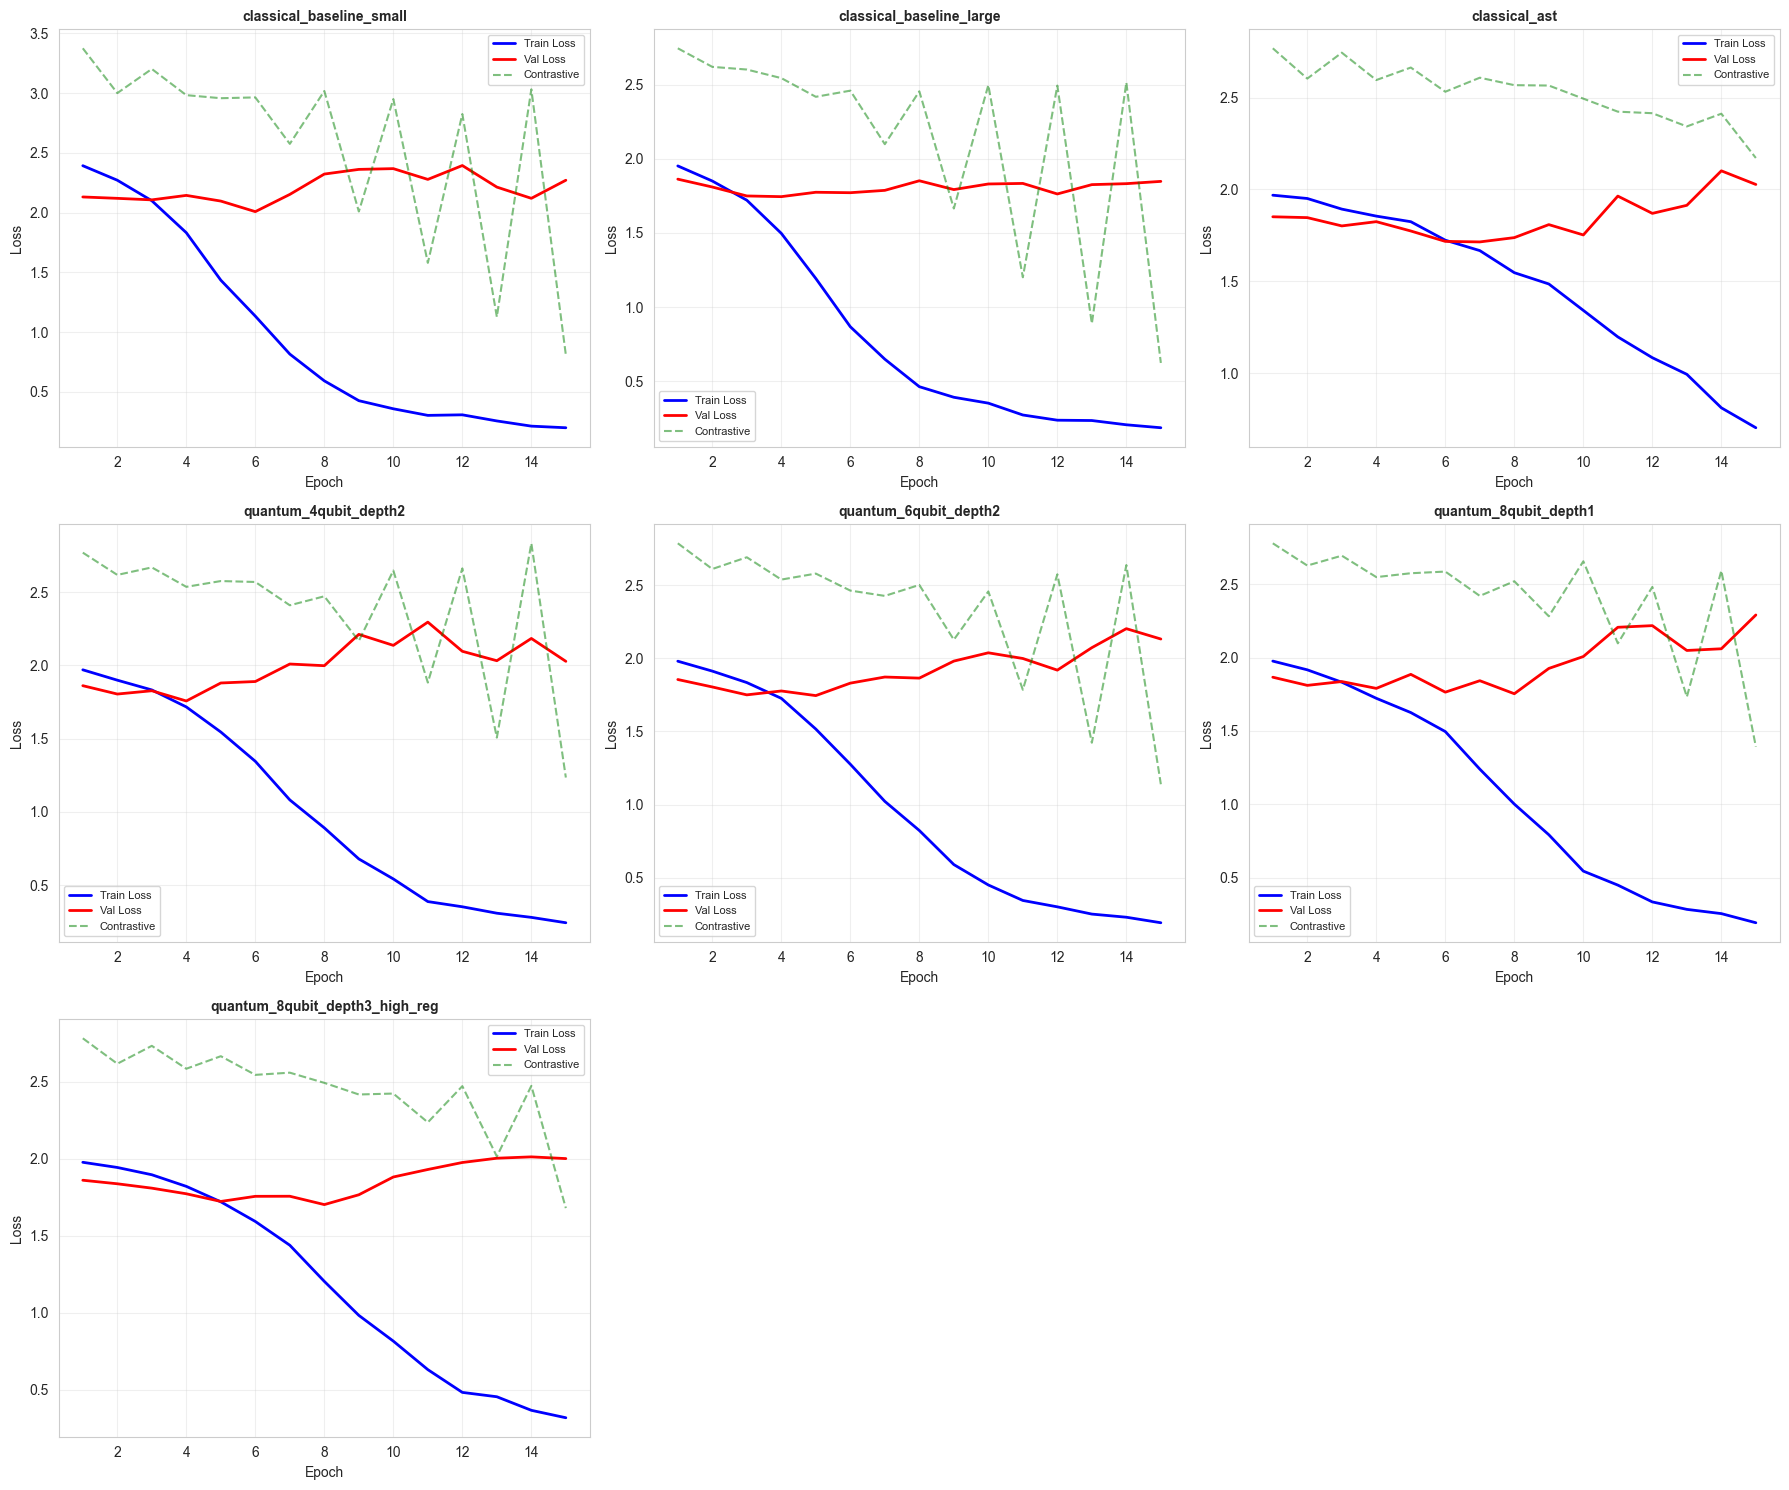

✓ Comparison plots saved to tuning_results/recovered_comparison.png


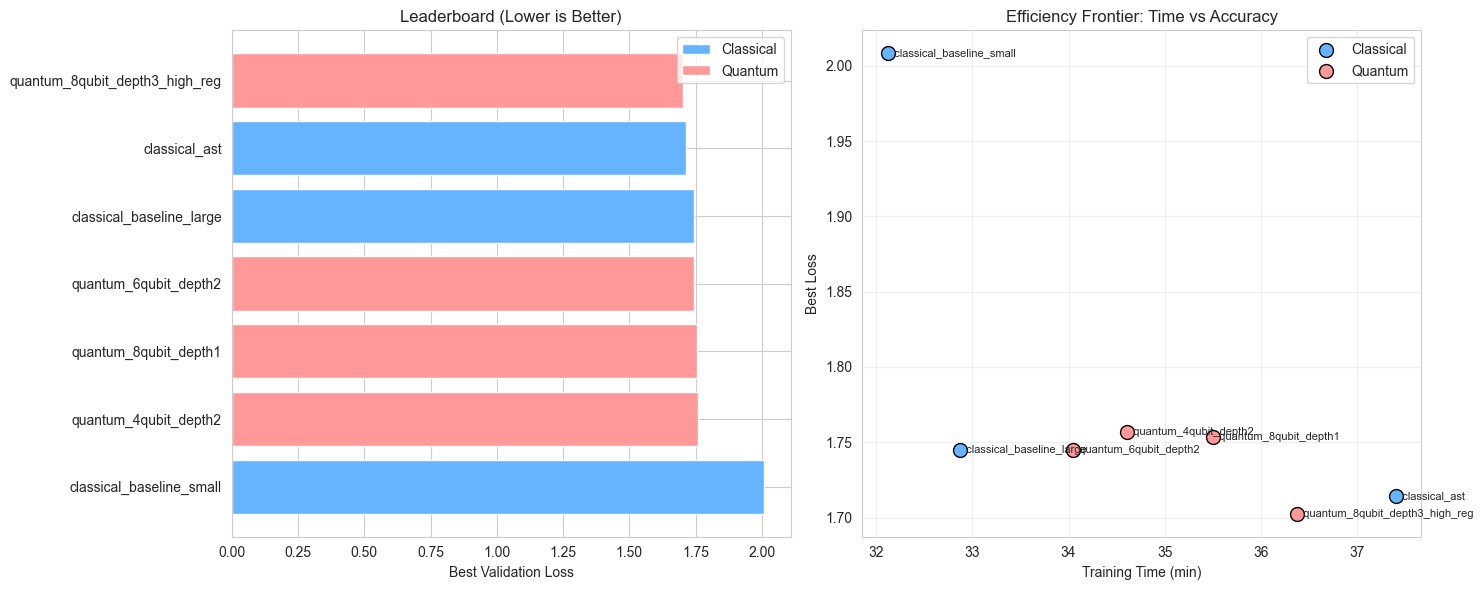

In [33]:
# 1. Parse the text file
df_epochs, df_meta = parse_logs_to_dataframe('raw_tuning_logs.txt')

# 2. Generate Summary Analysis (Requires your original hyperparameter_configs list)
df_summary = analyze_results_from_logs(df_epochs, df_meta, hyperparameter_configs)

# 3. Generate Plots
plot_training_curves_from_logs(df_epochs)
plot_comparison_from_summary(df_summary)

In [ ]:
def generate_final_report(results_df, all_results):
    """
    Generate a comprehensive text report of the hyperparameter search
    
    Args:
        results_df: DataFrame with summary statistics
        all_results: List of detailed results
    """
    report_path = Path('tuning_results') / 'final_report.txt'
    
    with open(report_path, 'w') as f:
        f.write("="*80 + "\n")
        f.write("LSTMABAR HYPERPARAMETER TUNING REPORT\n")
        f.write("="*80 + "\n\n")
        
        from datetime import datetime
        f.write(f"Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
        f.write(f"Total configurations tested: {len(all_results)}\n")
        f.write(f"Successful runs: {len(results_df)}\n\n")
        
        if len(results_df) == 0:
            f.write("No successful runs to report.\n")
            return
        
        # Best overall
        best = results_df.iloc[0]
        f.write("BEST OVERALL CONFIGURATION\n")
        f.write("-" * 80 + "\n")
        f.write(f"Name: {best['name']}\n")
        f.write(f"Type: {'Quantum' if best['quantum'] else 'Classical'}\n")
        f.write(f"Best Loss: {best['best_loss']:.4f} ({best['loss_type']})\n")
        f.write(f"Final Loss: {best['final_loss']:.4f}\n")
        f.write(f"Training Time: {best['training_time_min']:.2f} minutes\n")
        f.write(f"Embedding Dimension: {best['embedding_dim']}\n")
        f.write(f"Architecture: {best['architecture']}\n")
        f.write(f"Batch Size: {best['batch_size']}\n")
        f.write(f"Learning Rate: {best['learning_rate']}\n")
        if best['quantum']:
            f.write(f"Number of Qubits: {best.get('n_qubits', 'N/A')}\n")
        f.write("\n")
        
        # Classical comparison
        classical_df = results_df[results_df['quantum'] == False]
        if len(classical_df) > 0:
            f.write("BEST CLASSICAL CONFIGURATION\n")
            f.write("-" * 80 + "\n")
            best_classical = classical_df.iloc[0]
            f.write(f"Name: {best_classical['name']}\n")
            f.write(f"Best Loss: {best_classical['best_loss']:.4f}\n")
            f.write(f"Training Time: {best_classical['training_time_min']:.2f} minutes\n\n")
        
        # Quantum comparison
        quantum_df = results_df[results_df['quantum'] == True]
        if len(quantum_df) > 0:
            f.write("BEST QUANTUM CONFIGURATION\n")
            f.write("-" * 80 + "\n")
            best_quantum = quantum_df.iloc[0]
            f.write(f"Name: {best_quantum['name']}\n")
            f.write(f"Best Loss: {best_quantum['best_loss']:.4f}\n")
            f.write(f"Number of Qubits: {best_quantum.get('n_qubits', 'N/A')}\n")
            f.write(f"Training Time: {best_quantum['training_time_min']:.2f} minutes\n\n")
        
        # Full rankings
        f.write("FULL RANKINGS\n")
        f.write("-" * 80 + "\n")
        for idx, row in results_df.iterrows():
            f.write(f"{idx+1}. {row['name']}\n")
            f.write(f"   Loss: {row['best_loss']:.4f} | Time: {row['training_time_min']:.2f}min\n")
        
        f.write("\n" + "="*80 + "\n")
        f.write("END OF REPORT\n")
        f.write("="*80 + "\n")
    
    print(f"✓ Final report saved to {report_path}")
    
    # Also print to console
    with open(report_path, 'r') as f:
        print("\n" + f.read())

In [30]:
# Generate report
if len(results_df) > 0:
    generate_final_report(results_df, all_results)

print("\n" + "="*80)
print("HYPERPARAMETER TUNING ANALYSIS COMPLETE!")
print("="*80)
print("\nResults saved to:")
print("  - tuning_results/summary.csv")
print("  - tuning_results/training_curves.png")
print("  - tuning_results/comparison_plots.png")
print("  - tuning_results/final_report.txt")
if len(results_df) > 0:
    best_config_name = results_df.iloc[0]['name']
    print(f"\nBest model checkpoint:")
    print(f"  - tuning_checkpoints/{best_config_name}/best_model.pth")

✓ Final report saved to tuning_results/final_report.txt

LSTMABAR HYPERPARAMETER TUNING REPORT

Date: 2025-12-02 07:14:00
Total configurations tested: 10
Successful runs: 10

BEST OVERALL CONFIGURATION
--------------------------------------------------------------------------------
Name: classical_baseline_large
Type: Classical
Best Loss: 0.1752 (train)
Final Loss: 0.1927
Training Time: 33.17 minutes
Embedding Dimension: 768
Architecture: resnet
Batch Size: 16
Learning Rate: 5e-05

BEST CLASSICAL CONFIGURATION
--------------------------------------------------------------------------------
Name: classical_baseline_large
Best Loss: 0.1752
Training Time: 33.17 minutes

BEST QUANTUM CONFIGURATION
--------------------------------------------------------------------------------
Name: quantum_8qubit_depth1
Best Loss: 0.1927
Number of Qubits: 8.0
Training Time: 35.50 minutes

FULL RANKINGS
--------------------------------------------------------------------------------
3. classical_baseline_l

#### Generate final report from tuning logs

In [35]:
from pathlib import Path
from datetime import datetime
import pandas as pd

def generate_final_report_from_logs(df_summary, total_configs_count=None, output_dir='tuning_results'):
    """
    Generate a comprehensive text report using the recovered DataFrame.
    
    Args:
        df_summary: The DataFrame returned by analyze_results_from_logs
        total_configs_count: Optional int, total number of configs defined in your list
                             (useful to see if any crashed completely and are missing)
        output_dir: Directory to save the report
    """
    output_dir = Path(output_dir)
    output_dir.mkdir(exist_ok=True, parents=True)
    report_path = output_dir / 'final_report.txt'
    
    # Ensure df is sorted by best_loss
    df_summary = df_summary.sort_values('best_loss')
    
    with open(report_path, 'w') as f:
        f.write("="*80 + "\n")
        f.write("LSTMABAR HYPERPARAMETER TUNING REPORT (RECOVERED FROM LOGS)\n")
        f.write("="*80 + "\n\n")
        
        f.write(f"Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
        
        # Calculate counts
        successful_runs = len(df_summary)
        total_runs = total_configs_count if total_configs_count else successful_runs
        
        f.write(f"Total configurations accounted for: {total_runs}\n")
        f.write(f"Successful parsed runs: {successful_runs}\n")
        if total_runs > successful_runs:
            f.write(f"⚠️ Missing/Failed runs: {total_runs - successful_runs}\n")
        f.write("\n")
        
        if len(df_summary) == 0:
            f.write("No successful runs to report.\n")
            return
        
        # Best overall (First row, since we sorted)
        best = df_summary.iloc[0]
        f.write("BEST OVERALL CONFIGURATION\n")
        f.write("-" * 80 + "\n")
        f.write(f"Name: {best['name']}\n")
        f.write(f"Type: {'Quantum' if best['quantum'] else 'Classical'}\n")
        f.write(f"Best Loss: {best['best_loss']:.4f} ({best['loss_type']})\n")
        f.write(f"Final Loss: {best['final_loss']:.4f}\n")
        f.write(f"Training Time: {best['training_time_min']:.2f} minutes\n")
        f.write(f"Embedding Dimension: {best['embedding_dim']}\n")
        f.write(f"Architecture: {best['architecture']}\n")
        f.write(f"Batch Size: {best['batch_size']}\n")
        f.write(f"Learning Rate: {best['learning_rate']}\n")
        
        # Handle N/A for quantum params safely
        if best['quantum']:
            f.write(f"Number of Qubits: {best.get('n_qubits', 'N/A')}\n")
            f.write(f"Circuit Depth: {best.get('circuit_depth', 'N/A')}\n")
        f.write("\n")
        
        # Classical comparison
        classical_df = df_summary[df_summary['quantum'] == False]
        if len(classical_df) > 0:
            f.write("BEST CLASSICAL CONFIGURATION\n")
            f.write("-" * 80 + "\n")
            # Since df_summary is sorted by loss, the first classical entry is the best classical
            best_classical = classical_df.iloc[0]
            f.write(f"Name: {best_classical['name']}\n")
            f.write(f"Best Loss: {best_classical['best_loss']:.4f}\n")
            f.write(f"Training Time: {best_classical['training_time_min']:.2f} minutes\n\n")
        
        # Quantum comparison
        quantum_df = df_summary[df_summary['quantum'] == True]
        if len(quantum_df) > 0:
            f.write("BEST QUANTUM CONFIGURATION\n")
            f.write("-" * 80 + "\n")
            # Since df_summary is sorted by loss, the first quantum entry is the best quantum
            best_quantum = quantum_df.iloc[0]
            f.write(f"Name: {best_quantum['name']}\n")
            f.write(f"Best Loss: {best_quantum['best_loss']:.4f}\n")
            f.write(f"Number of Qubits: {best_quantum.get('n_qubits', 'N/A')}\n")
            f.write(f"Training Time: {best_quantum['training_time_min']:.2f} minutes\n\n")
        
        # Full rankings
        f.write("FULL RANKINGS (Ordered by Loss)\n")
        f.write("-" * 80 + "\n")
        
        # Re-indexing from 1 for the leaderboard
        rank = 1
        for _, row in df_summary.iterrows():
            f.write(f"{rank}. {row['name']}\n")
            f.write(f"   Loss: {row['best_loss']:.4f} | Time: {row['training_time_min']:.2f}min | Epochs: {row['epochs_completed']}\n")
            rank += 1
        
        f.write("\n" + "="*80 + "\n")
        f.write("END OF REPORT\n")
        f.write("="*80 + "\n")
    
    print(f"✓ Final report saved to {report_path}")
    
    # Also print to console
    with open(report_path, 'r') as f:
        print("\n" + f.read())

In [36]:
# 4. Generate Text Report
generate_final_report_from_logs(
    df_summary, 
    total_configs_count=len(hyperparameter_configs) # Optional: passes 7
)

✓ Final report saved to tuning_results/final_report.txt

LSTMABAR HYPERPARAMETER TUNING REPORT (RECOVERED FROM LOGS)

Date: 2025-12-02 07:55:56
Total configurations accounted for: 7
Successful parsed runs: 7

BEST OVERALL CONFIGURATION
--------------------------------------------------------------------------------
Name: quantum_8qubit_depth3_high_reg
Type: Quantum
Best Loss: 1.7026 (val)
Final Loss: 2.0012
Training Time: 36.37 minutes
Embedding Dimension: 768
Architecture: resnet
Batch Size: 16
Learning Rate: 5e-05
Number of Qubits: 8.0
Circuit Depth: 3.0

BEST CLASSICAL CONFIGURATION
--------------------------------------------------------------------------------
Name: classical_ast
Best Loss: 1.7145
Training Time: 37.40 minutes

BEST QUANTUM CONFIGURATION
--------------------------------------------------------------------------------
Name: quantum_8qubit_depth3_high_reg
Best Loss: 1.7026
Number of Qubits: 8.0
Training Time: 36.37 minutes

FULL RANKINGS (Ordered by Loss)
-----------